1. Imports

In [292]:
# !pip install missingno

In [293]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

from sklearn.impute import KNNImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, MinMaxScaler, RobustScaler

from sklearn.model_selection import train_test_split, cross_validate, learning_curve, validation_curve, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, SVR

from sklearn.metrics import mean_squared_error, make_scorer, recall_score, precision_score

import joblib

# %load_ext autoreload
#%autoreload 2

In [294]:
df = pd.read_csv("healthcare-dataset-stroke-data.csv")

In [295]:
df.head(5)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [296]:
df.ever_married.value_counts()

ever_married
Yes    3353
No     1757
Name: count, dtype: int64

In [297]:
df[df.stroke ==1].smoking_status.value_counts()

smoking_status
never smoked       90
formerly smoked    70
Unknown            47
smokes             42
Name: count, dtype: int64

In [298]:
df.isnull().sum().sort_values(ascending=False)/len(df)

bmi                  0.039335
id                   0.000000
gender               0.000000
age                  0.000000
hypertension         0.000000
heart_disease        0.000000
ever_married         0.000000
work_type            0.000000
Residence_type       0.000000
avg_glucose_level    0.000000
smoking_status       0.000000
stroke               0.000000
dtype: float64

In [299]:
df.gender.value_counts()

gender
Female    2994
Male      2115
Other        1
Name: count, dtype: int64

2. Data Analysis

In [300]:
df.describe().applymap(lambda x: round(x, 3))

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000,5110.000,5110.000,5110.000,5110.000,4909.000,5110.000
mean,36517.829,43.227,0.097,0.054,106.148,28.893,0.049
std,21161.722,22.613,0.297,0.226,45.284,7.854,0.215
min,67.000,0.080,0.000,0.000,55.120,10.300,0.000
25%,17741.250,25.000,0.000,0.000,77.245,23.500,0.000
50%,36932.000,45.000,0.000,0.000,91.885,28.100,0.000
75%,54682.000,61.000,0.000,0.000,114.090,33.100,0.000
max,72940.000,82.000,1.000,1.000,271.740,97.600,1.000


In [301]:
# plt.figure(figsize = (50,50))
# sns.heatmap(round(df.corr(),2), cmap = "coolwarm", annot = True, annot_kws = {"size":12})

In [302]:
# plt.figure(figsize=(15,4))

# sns.regplot(x='age', y='stroke', data=df.sample(100, random_state=9), ci=95)

In [303]:
df.nunique()[df.nunique() == 2]

hypertension      2
heart_disease     2
ever_married      2
Residence_type    2
stroke            2
dtype: int64

In [304]:
df.drop(columns=['id']).nunique()[df.nunique() != 2]

gender                  3
age                   104
work_type               5
avg_glucose_level    3979
bmi                   418
smoking_status          4
dtype: int64

In [305]:
# Display numerics columns
df.select_dtypes(include=['int64', 'float64'])

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
0,9046,67.0,0,1,228.69,36.6,1
1,51676,61.0,0,0,202.21,NaN,1
2,31112,80.0,0,1,105.92,32.5,1
3,60182,49.0,0,0,171.23,34.4,1
4,1665,79.0,1,0,174.12,24.0,1
...,...,...,...,...,...,...,...
5105,18234,80.0,1,0,83.75,NaN,0
5106,44873,81.0,0,0,125.20,40.0,0
5107,19723,35.0,0,0,82.99,30.6,0
5108,37544,51.0,0,0,166.29,25.6,0


In [306]:
# Display Objects columns
df.select_dtypes(include=['O'])

,gender,ever_married,work_type,Residence_type,smoking_status
0,Male,Yes,Private,Urban,formerly smoked
1,Female,Yes,Self-employed,Rural,never smoked
2,Male,Yes,Private,Rural,never smoked
3,Female,Yes,Private,Urban,smokes
4,Female,Yes,Self-employed,Rural,never smoked
...,...,...,...,...,...
5105,Female,Yes,Private,Urban,never smoked
5106,Female,Yes,Self-employed,Urban,never smoked
5107,Female,Yes,Self-employed,Rural,never smoked
5108,Male,Yes,Private,Rural,formerly smoked


In [307]:
# curves_step = [1, 200, 300, 400, 500, 600, 650, 712]
# train_sizes, train_scores, test_scores = learning_curve(
#     estimator=LogisticRegression(), X=X, y=y, train_sizes=curves_step, cv=5)
# train_scores_mean = np.mean(train_scores, axis=1)
# test_scores_mean = np.mean(test_scores, axis=1)
# plt.plot(train_sizes, train_scores_mean, label = 'Training score')
# plt.plot(train_sizes, test_scores_mean, label = 'Test score')
# plt.ylabel('r2 score', fontsize = 14)
# plt.xlabel('Training set size', fontsize = 14)
# plt.title('Learning curves', fontsize = 18, y = 1.03)
# plt.legend()

In [308]:
# df.shape
# df.isna()
percent_missing = df.isnull().sum() * 100 / len(df)
missing_value_df = pd.DataFrame({'column_name': df.columns,
                                 'percent_missing': percent_missing})
missing_value_df.sort_values('percent_missing', inplace=True)
percent_missing = df.isnull().sum() * 100 / len(df)
percent_missing.sort_values(ascending=False).head(15)


bmi                  3.933464
id                   0.000000
gender               0.000000
age                  0.000000
hypertension         0.000000
heart_disease        0.000000
ever_married         0.000000
work_type            0.000000
Residence_type       0.000000
avg_glucose_level    0.000000
smoking_status       0.000000
stroke               0.000000
dtype: float64

In [309]:
# df.gender.value_counts()
df.age.min()


0.08

In [310]:
df.age.count()

5110

En outlier sur la colonne age on à un avc recensé à 2 ans et un autre à 16 ans 

In [311]:
df[df.age<32].stroke.value_counts()

stroke
0    1647
1       2
Name: count, dtype: int64

In [312]:
df[df.age<39].stroke.value_counts()

stroke
0    2094
1       5
Name: count, dtype: int64

In [313]:
df[df.age<32].stroke.value_counts()/1649*100

stroke
0    99.878714
1     0.121286
Name: count, dtype: float64

In [314]:
df[df.age<38].stroke.value_counts()

stroke
0    2024
1       3
Name: count, dtype: int64

In [315]:
df.avg_glucose_level.min()


55.12

In [316]:
df.avg_glucose_level.max()

271.74

In [317]:
df.bmi.isna().value_counts()

bmi
False    4909
True      201
Name: count, dtype: int64

In [318]:
df.smoking_status.value_counts()

smoking_status
never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: count, dtype: int64

In [319]:
df.stroke.value_counts()

stroke
0    4861
1     249
Name: count, dtype: int64

In [320]:
df.work_type

0             Private
1       Self-employed
2             Private
3             Private
4       Self-employed
            ...      
5105          Private
5106    Self-employed
5107    Self-employed
5108          Private
5109         Govt_job
Name: work_type, Length: 5110, dtype: object

3. Feature Engineering

In [321]:
clean_df = df[df.gender != 'Other']
# on va en discuter tkt
clean_df = clean_df[clean_df.age>30]

In [322]:
df.gender.value_counts()

gender
Female    2994
Male      2115
Other        1
Name: count, dtype: int64

In [323]:
df.ever_married = df.ever_married.apply(lambda x : 1 if x == "Yes" else 0)


In [324]:
df.Residence_type.value_counts()
df.Residence_type = df.Residence_type.apply(lambda x : 1 if x == "Urban" else 0)
df.Residence_type.value_counts()


Residence_type
1    2596
0    2514
Name: count, dtype: int64

In [325]:
df

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,1,Private,1,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,1,Self-employed,0,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,1,Private,0,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,1,Private,1,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,1,Self-employed,0,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,1,Private,1,83.75,NaN,never smoked,0
5106,44873,Female,81.0,0,0,1,Self-employed,1,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,1,Self-employed,0,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,1,Private,0,166.29,25.6,formerly smoked,0


In [326]:
df

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,1,Private,1,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,1,Self-employed,0,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,1,Private,0,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,1,Private,1,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,1,Self-employed,0,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,1,Private,1,83.75,NaN,never smoked,0
5106,44873,Female,81.0,0,0,1,Self-employed,1,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,1,Self-employed,0,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,1,Private,0,166.29,25.6,formerly smoked,0


In [327]:

label_encoder = LabelEncoder()
label_encoder.fit_transform(df.work_type)


array([2, 3, 2, ..., 3, 2, 0])

In [328]:
# from sklearn.preprocessing import OneHotEncoder

# categorical_column_reshaped = df.work_type.values.reshape(-1, 1)

# OneHotEncoder(sparse_output=False).fit_transform(categorical_column_reshaped)

In [329]:
df.work_type[0:20]

0           Private
1     Self-employed
2           Private
3           Private
4     Self-employed
5           Private
6           Private
7           Private
8           Private
9           Private
10          Private
11         Govt_job
12          Private
13          Private
14          Private
15    Self-employed
16          Private
17          Private
18          Private
19         Govt_job
Name: work_type, dtype: object

In [330]:
df.work_type.value_counts()

work_type
Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: count, dtype: int64

In [331]:

# CentralAir_encoder = OneHotEncoder(sparse=False, drop='if_binary', categories=[['Private', 'Self-employed', 'children', 'Govt_job', 'Never_worked' ]]) # Instanciate encoder
# df['CentralAir'] = CentralAir_encoder.fit_transform(df.work_type) # Fit encoder and tranform

In [332]:
df = pd.read_csv("healthcare-dataset-stroke-data.csv")
clean_df = df.copy()

if "Other" in clean_df.gender.value_counts():
    clean_df = df[df.gender != 'Other']
    # on va en discuter tkt
    clean_df = clean_df[clean_df.age>30]


    # clean_df = clean_df.dropna(axis=0, subset='bmi')

    # binaires à faire dans la pipeline dans le script bonus
    clean_df.ever_married = clean_df.ever_married.apply(lambda x : 1 if x == "Yes" else 0)
    clean_df.Residence_type = clean_df.Residence_type.apply(lambda x : 1 if x == "Urban" else 0)
    clean_df.gender = clean_df.gender.apply(lambda x : 1 if x == "Female" else 0)



    clean_df['bmi'] = clean_df['bmi'].fillna(df['bmi'].median())
    # from Sacia
    clean_df = clean_df[clean_df.bmi <= 60]

    # A CHANGER ABSOLUMENT
    clean_df.bmi.fillna(0, inplace=True)


{'bodies': [<matplotlib.collections.PolyCollection at 0x7feb6d7eaa60>],
 'cmaxes': <matplotlib.collections.LineCollection at 0x7feb6d7ea970>,
 'cmins': <matplotlib.collections.LineCollection at 0x7feb6d7ea9a0>,
 'cbars': <matplotlib.collections.LineCollection at 0x7feb6d7f63a0>}

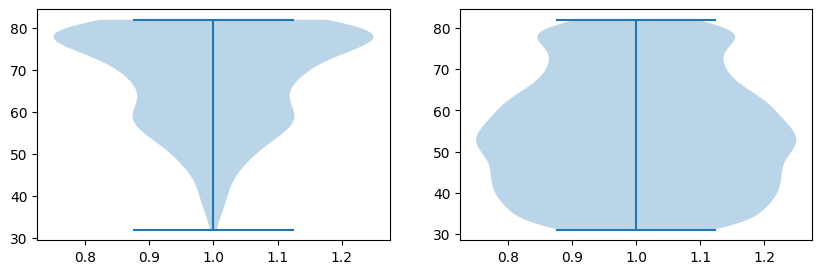

In [333]:
clean_df
f = plt.figure(figsize=(10,3))
ax = f.add_subplot(121)
plt.violinplot(clean_df.age[clean_df.stroke == 1])
ax2 = f.add_subplot(122)
plt.violinplot(clean_df.age[clean_df.stroke != 1])

{'bodies': [<matplotlib.collections.PolyCollection at 0x7feb6d74d460>],
 'cmaxes': <matplotlib.collections.LineCollection at 0x7feb6d74d370>,
 'cmins': <matplotlib.collections.LineCollection at 0x7feb6d74da00>,
 'cbars': <matplotlib.collections.LineCollection at 0x7feb6d74dd60>}

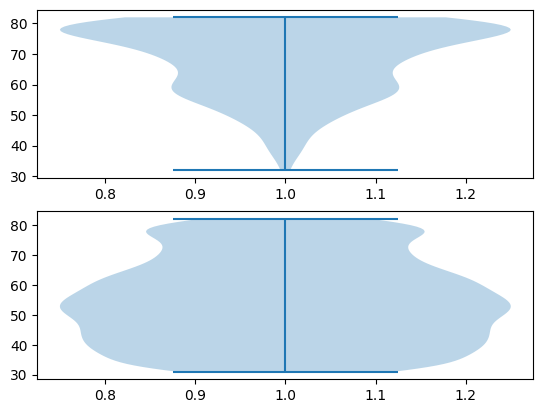

In [334]:
fig, axs = plt.subplots(2)
axs[0].violinplot(clean_df.age[clean_df.stroke == 1])
axs[1].violinplot(clean_df.age[clean_df.stroke != 1])

{'bodies': [<matplotlib.collections.PolyCollection at 0x7feb6d62efd0>],
 'cmaxes': <matplotlib.collections.LineCollection at 0x7feb6d62eee0>,
 'cmins': <matplotlib.collections.LineCollection at 0x7feb6d63e5b0>,
 'cbars': <matplotlib.collections.LineCollection at 0x7feb6d63e910>}

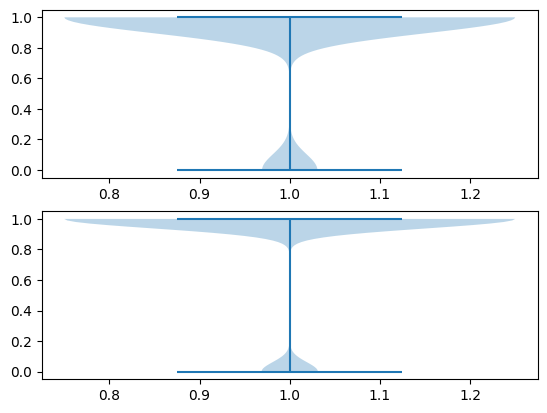

In [335]:
fig, axs = plt.subplots(2)
axs[0].violinplot(clean_df.ever_married[clean_df.stroke == 1])
axs[1].violinplot(clean_df.ever_married[clean_df.stroke != 1])

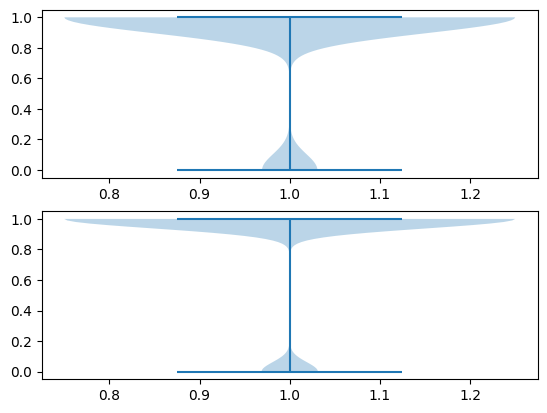

In [336]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2)
violin1 = axs[0].violinplot(clean_df.ever_married[clean_df.stroke == 1])
violin2 = axs[1].violinplot(clean_df.ever_married[clean_df.stroke != 1])


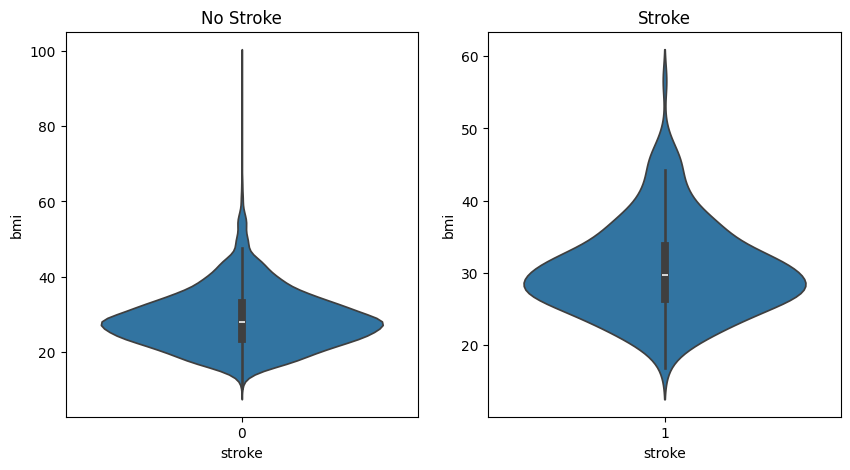

In [337]:

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

sns.violinplot(x='stroke', y='bmi', data=df[df.stroke != 1].dropna(), ax=axs[0])
sns.violinplot(x='stroke', y='bmi', data=df[df.stroke == 1].dropna(), ax=axs[1])

axs[0].set_title('No Stroke')
axs[1].set_title('Stroke')

plt.show()


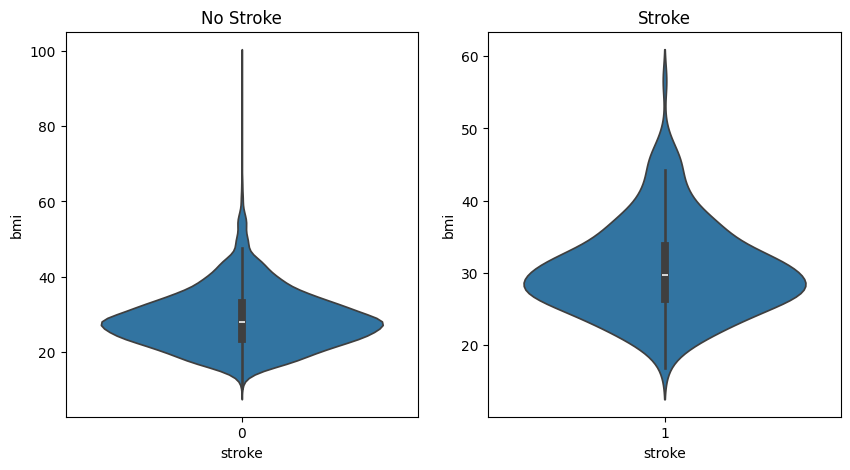

In [338]:

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

sns.violinplot(x='stroke', y='bmi', data=df[df.stroke != 1], ax=axs[0])
sns.violinplot(x='stroke', y='bmi', data=df[df.stroke == 1], ax=axs[1])

axs[0].set_title('No Stroke')
axs[1].set_title('Stroke')

plt.show()


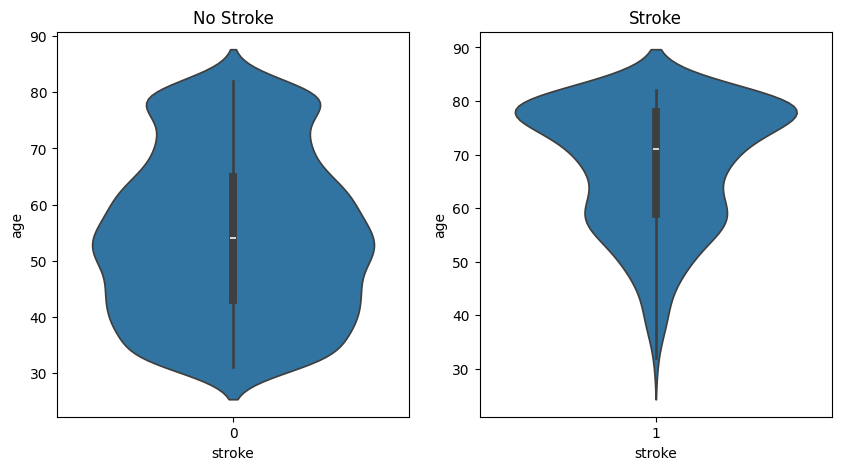

In [339]:

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

sns.violinplot(x='stroke', y='age', data=clean_df[clean_df.stroke != 1], ax=axs[0])
sns.violinplot(x='stroke', y='age', data=clean_df[clean_df.stroke == 1], ax=axs[1])

axs[0].set_title('No Stroke')
axs[1].set_title('Stroke')

plt.show()


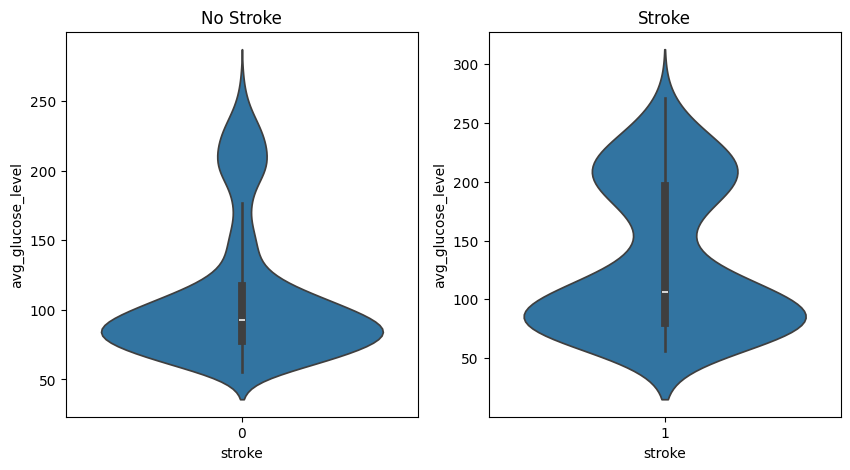

In [340]:

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

sns.violinplot(x='stroke', y='avg_glucose_level', data=clean_df[clean_df.stroke != 1], ax=axs[0])
sns.violinplot(x='stroke', y='avg_glucose_level', data=clean_df[clean_df.stroke == 1], ax=axs[1])

axs[0].set_title('No Stroke')
axs[1].set_title('Stroke')

plt.show()


In [341]:
clean_df.stroke.value_counts(normalize=True)

stroke
0    0.930048
1    0.069952
Name: proportion, dtype: float64

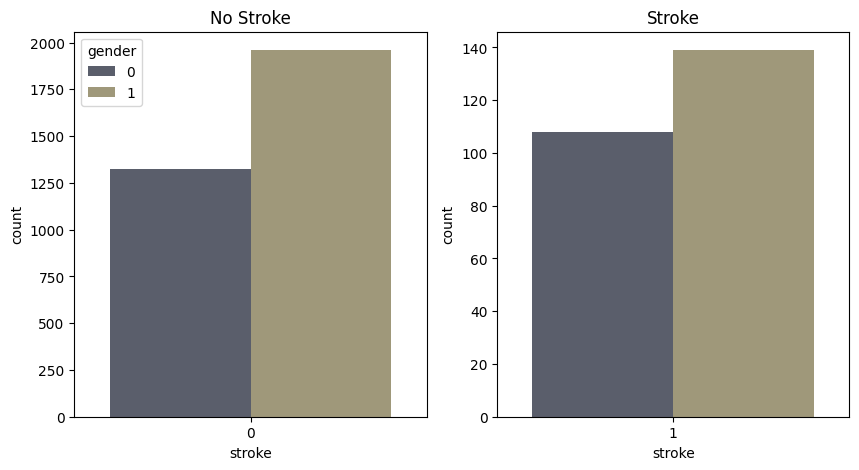

In [342]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
sns.countplot(x='stroke', hue='gender', data=clean_df[clean_df.stroke ==0], palette='cividis', ax=axs[0])
sns.countplot(x='stroke', hue='gender', data=clean_df[clean_df.stroke ==1], palette='cividis', ax=axs[1])

axs[0].set_title('No Stroke')
axs[1].set_title('Stroke')
axs[1].legend_.remove()

plt.show()


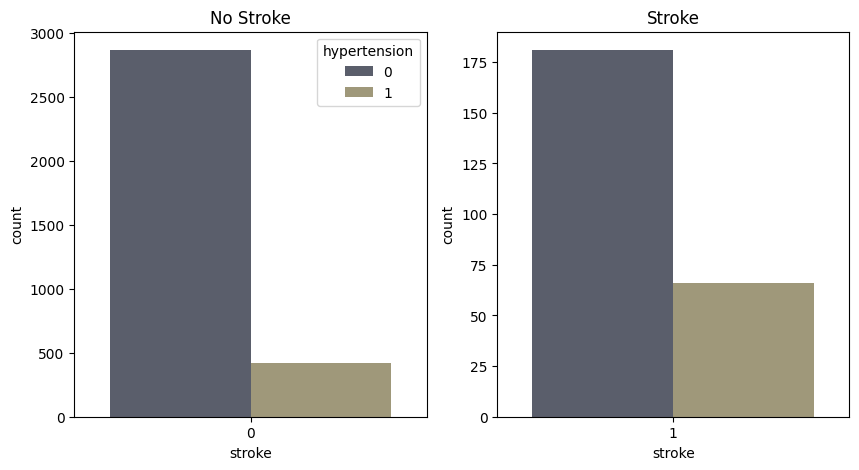

In [343]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
sns.countplot(x='stroke', hue='hypertension', data=clean_df[clean_df.stroke ==0], palette='cividis', ax=axs[0])
sns.countplot(x='stroke', hue='hypertension', data=clean_df[clean_df.stroke ==1], palette='cividis', ax=axs[1])

axs[0].set_title('No Stroke')
axs[1].set_title('Stroke')
axs[1].legend_.remove()

plt.show()


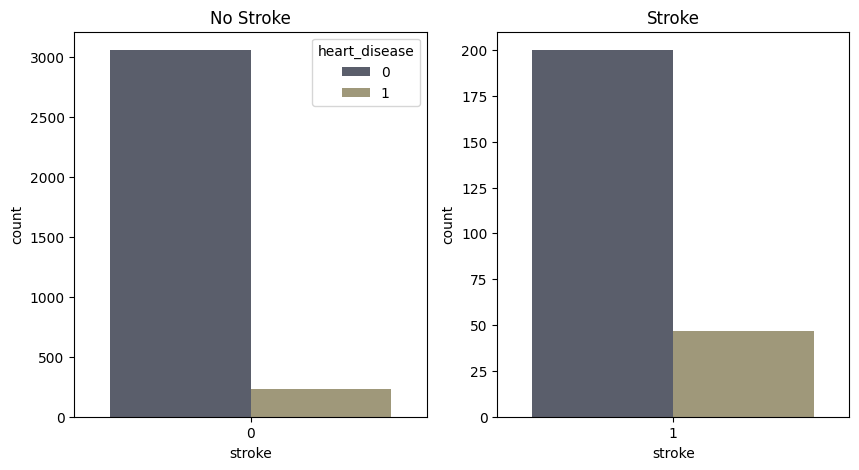

In [344]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
sns.countplot(x='stroke', hue='heart_disease', data=clean_df[clean_df.stroke ==0], palette='cividis', ax=axs[0])
sns.countplot(x='stroke', hue='heart_disease', data=clean_df[clean_df.stroke ==1], palette='cividis', ax=axs[1])

axs[0].set_title('No Stroke')
axs[1].set_title('Stroke')
axs[1].legend_.remove()

plt.show()


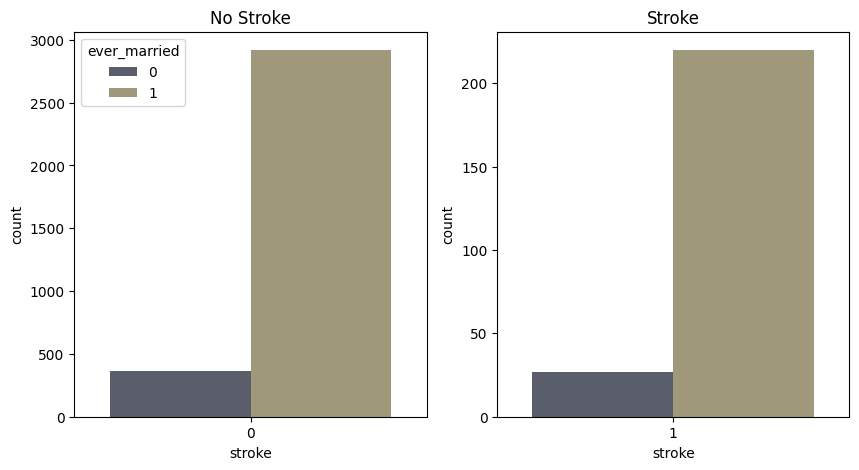

In [345]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
sns.countplot(x='stroke', hue='ever_married', data=clean_df[clean_df.stroke ==0], palette='cividis', ax=axs[0])
sns.countplot(x='stroke', hue='ever_married', data=clean_df[clean_df.stroke ==1], palette='cividis', ax=axs[1])

axs[0].set_title('No Stroke')
axs[1].set_title('Stroke')
axs[1].legend_.remove()

plt.show()


In [346]:
clean_df[clean_df.stroke !=1]['ever_married'].value_counts(normalize=True)

ever_married
1    0.888855
0    0.111145
Name: proportion, dtype: float64

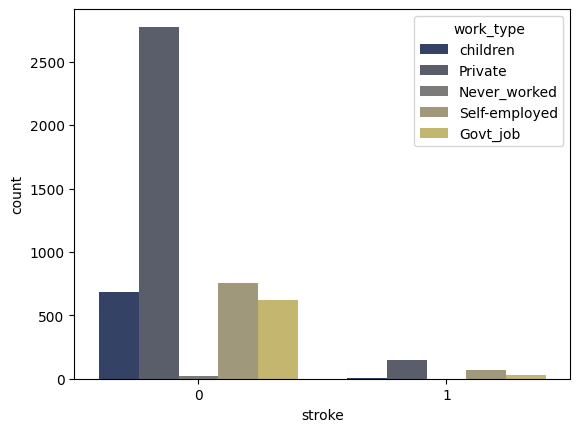

In [347]:
sns.countplot(x='stroke', hue='work_type', data=df, palette="cividis")
plt.show()

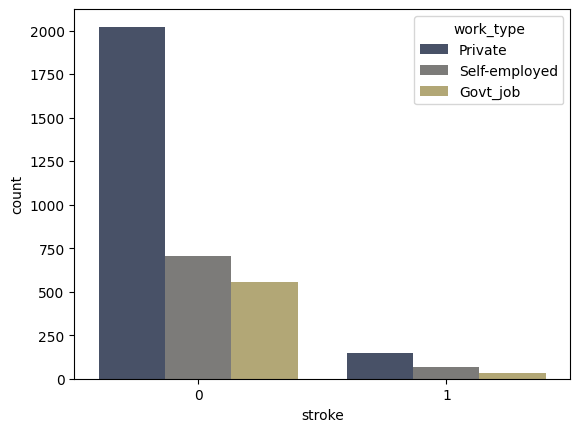

In [348]:
sns.countplot(x='stroke', hue='work_type', data=clean_df, palette='cividis')
plt.show()


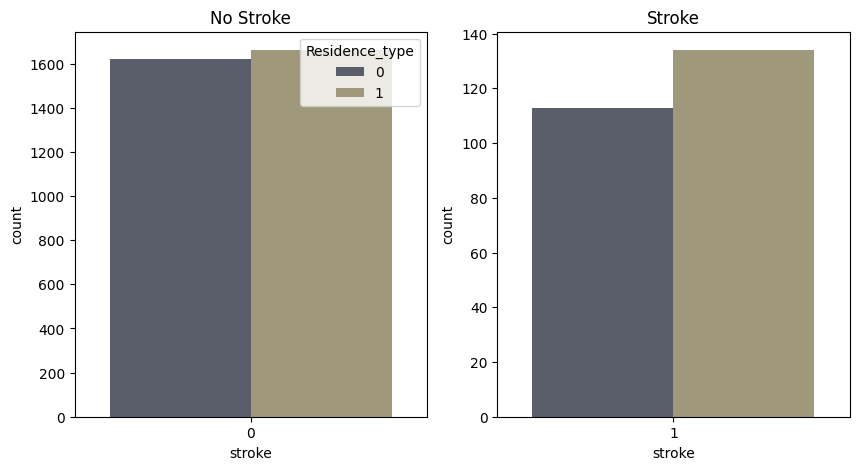

In [349]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
sns.countplot(x='stroke', hue='Residence_type', data=clean_df[clean_df.stroke ==0], palette='cividis', ax=axs[0])
sns.countplot(x='stroke', hue='Residence_type', data=clean_df[clean_df.stroke ==1], palette='cividis', ax=axs[1])

axs[0].set_title('No Stroke')
axs[1].set_title('Stroke')
axs[1].legend_.remove()

plt.show()


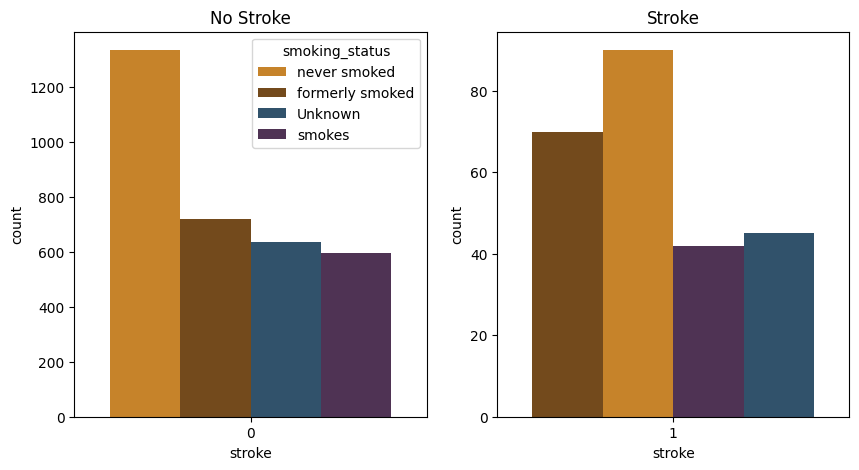

In [350]:
custom_palette = {'Unknown': '#275375', 'formerly smoked': '#824b0d', 'never smoked': '#e08610', 'smokes': '#532e59'}

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
sns.countplot(x='stroke', hue='smoking_status', data=clean_df[clean_df.stroke ==0], palette=custom_palette, ax=axs[0])
sns.countplot(x='stroke', hue='smoking_status', data=clean_df[clean_df.stroke ==1], palette=custom_palette, ax=axs[1])

axs[0].set_title('No Stroke')
axs[1].set_title('Stroke')
axs[1].legend_.remove()

plt.show()


In [351]:
clean_df[clean_df.stroke ==1].smoking_status.value_counts()

smoking_status
never smoked       90
formerly smoked    70
Unknown            45
smokes             42
Name: count, dtype: int64

In [352]:
df

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


In [353]:
from sklearn.svm import SVC

In [354]:
clean_df[clean_df.age<40]

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
49,36338,1,39.0,1,0,1,Private,0,58.09,39.2,smokes,1
118,31720,1,38.0,0,0,0,Self-employed,1,82.28,24.0,formerly smoked,1
133,31563,1,38.0,0,0,1,Private,0,101.45,28.1,formerly smoked,1
182,39912,1,32.0,0,0,1,Private,0,76.13,29.9,smokes,1
210,33943,1,39.0,0,0,1,Private,1,83.24,26.3,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5065,7789,1,31.0,0,0,1,Private,1,89.01,37.4,never smoked,0
5066,40112,1,37.0,0,0,0,Private,1,118.41,25.1,never smoked,0
5072,71957,1,35.0,0,0,1,Private,0,58.72,40.0,smokes,0
5076,39935,1,34.0,0,0,1,Private,0,174.37,23.0,never smoked,0


In [355]:
pd.DataFrame(clean_df.iloc[118,:]).transpose()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
118,31720,1,38.0,0,0,0,Self-employed,1,82.28,24.0,formerly smoked,1


In [356]:

to_classify = ['smoking_status' ]
to_robust = ['age', 'bmi']
already_processed = ['Residence_type', 'gender']

select_features = to_classify + to_robust + already_processed # + to_min_max

X = clean_df[select_features]
y = clean_df['stroke']  # Target

r2list = []
rmse_list = []
recall_list = []

# allow more accurate model's performance estimation with more training reps and
# different data splits on a small amount of data, needs to be 1 for prediction tasks.
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, \
        random_state=np.random.randint(1, 20001))

    # Building Pipeline
    preprocessor = ColumnTransformer([
        ('onehot', OneHotEncoder(), to_classify),
        ('robust_scaler', MinMaxScaler(), to_robust), # RobustScaler/StandardScaler
        # ('minmax', MinMaxScaler(), to_min_max),
    ], remainder='passthrough')  # passthrough/drop

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('random_forest', SVC(random_state=0, class_weight='balanced', probability = True, max_iter= 20000, gamma='auto')) #class_weight
        # ('regressor', LogisticRegression(penalty='l2', max_iter=1000, class_weight='balanced', n_jobs=8))  # Linear Regression model class_weight='balanced'
    ])
    pipeline.fit(X_train, y_train)

    r2list.append(pipeline.score(X_test, y_test))

    predicted_strokes = pipeline.predict(X_test)


    rmse_list.append(np.sqrt(mean_squared_error(y_test, predicted_strokes)))
    recall_list.append(recall_score(y_test, predicted_strokes))
    if recall_list[-1] == max(recall_list) :
        joblib.dump(pipeline, 'app/app_model/model.pkl')

print(f"# Used features count : {len(select_features) } - {select_features}") #/len(df.columns)
print(f"# Mean Recall: {np.mean(recall_list):.5f}")
print(f"# Mean r2 Test_Score: {np.mean(r2list):.5f}")
# Display RMSE
print(f"# Average prediction error: ~{np.mean(rmse_list):.4f} (RMSE)")


print(f"min/max recall result{[min(recall_list), max(recall_list)]}")

# Used features count : 5 - ['smoking_status', 'age', 'bmi', 'Residence_type', 'gender']
# Mean Recall: 0.73776
# Mean r2 Test_Score: 0.65415
# Average prediction error: ~0.5879 (RMSE)
min/max recall result[0.6973684210526315, 0.8082191780821918]


In [357]:
clean_df.iloc[118,:]

id                             31720
gender                             1
age                             38.0
hypertension                       0
heart_disease                      0
ever_married                       0
work_type              Self-employed
Residence_type                     1
avg_glucose_level              82.28
bmi                             24.0
smoking_status       formerly smoked
stroke                             1
Name: 118, dtype: object

In [358]:
# pd.DataFrame(clean_df.iloc[118,:][['smoking_status', 'age', 'bmi', 'Residence_type', 'gender']],\
#     columns=['smoking_status', 'age', 'bmi', 'Residence_type', 'gender'])

In [359]:
clean_df.iloc[118,:].index

Index(['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')

In [360]:
# should be 0 with that background

pipeline.predict(pd.DataFrame(clean_df.iloc[118,:]).transpose())


array([0])

4. Machine Learning


In [361]:
df_x = df.drop(columns ="stroke")
df_y = df['stroke']
# model = LogisticRegression()
# model.fit(df_x, df_y)
# accuracy = model.score(df_x,df_y)

In [362]:
# df = pd.read_csv("healthcare-dataset-stroke-data.csv")
# clean_df = df.copy()

# if "Other" in clean_df.gender.value_counts():
#     clean_df = df[df.gender != 'Other']
#     # on va en discuter tkt
#     clean_df = clean_df[clean_df.age>30]

#     clean_df.ever_married = clean_df.ever_married.apply(lambda x : 1 if x == "Yes" else 0)
#     clean_df.Residence_type = clean_df.Residence_type.apply(lambda x : 1 if x == "Urban" else 0)
#     clean_df.gender = clean_df.gender.apply(lambda x : 1 if x == "Female" else 0)

#     # from Sacia
#     clean_df = clean_df[clean_df.bmi <= 60]

#     # A CHANGER ABSOLUMENT
#     clean_df = clean_df.dropna(axis=0, subset='bmi')


<Axes: >

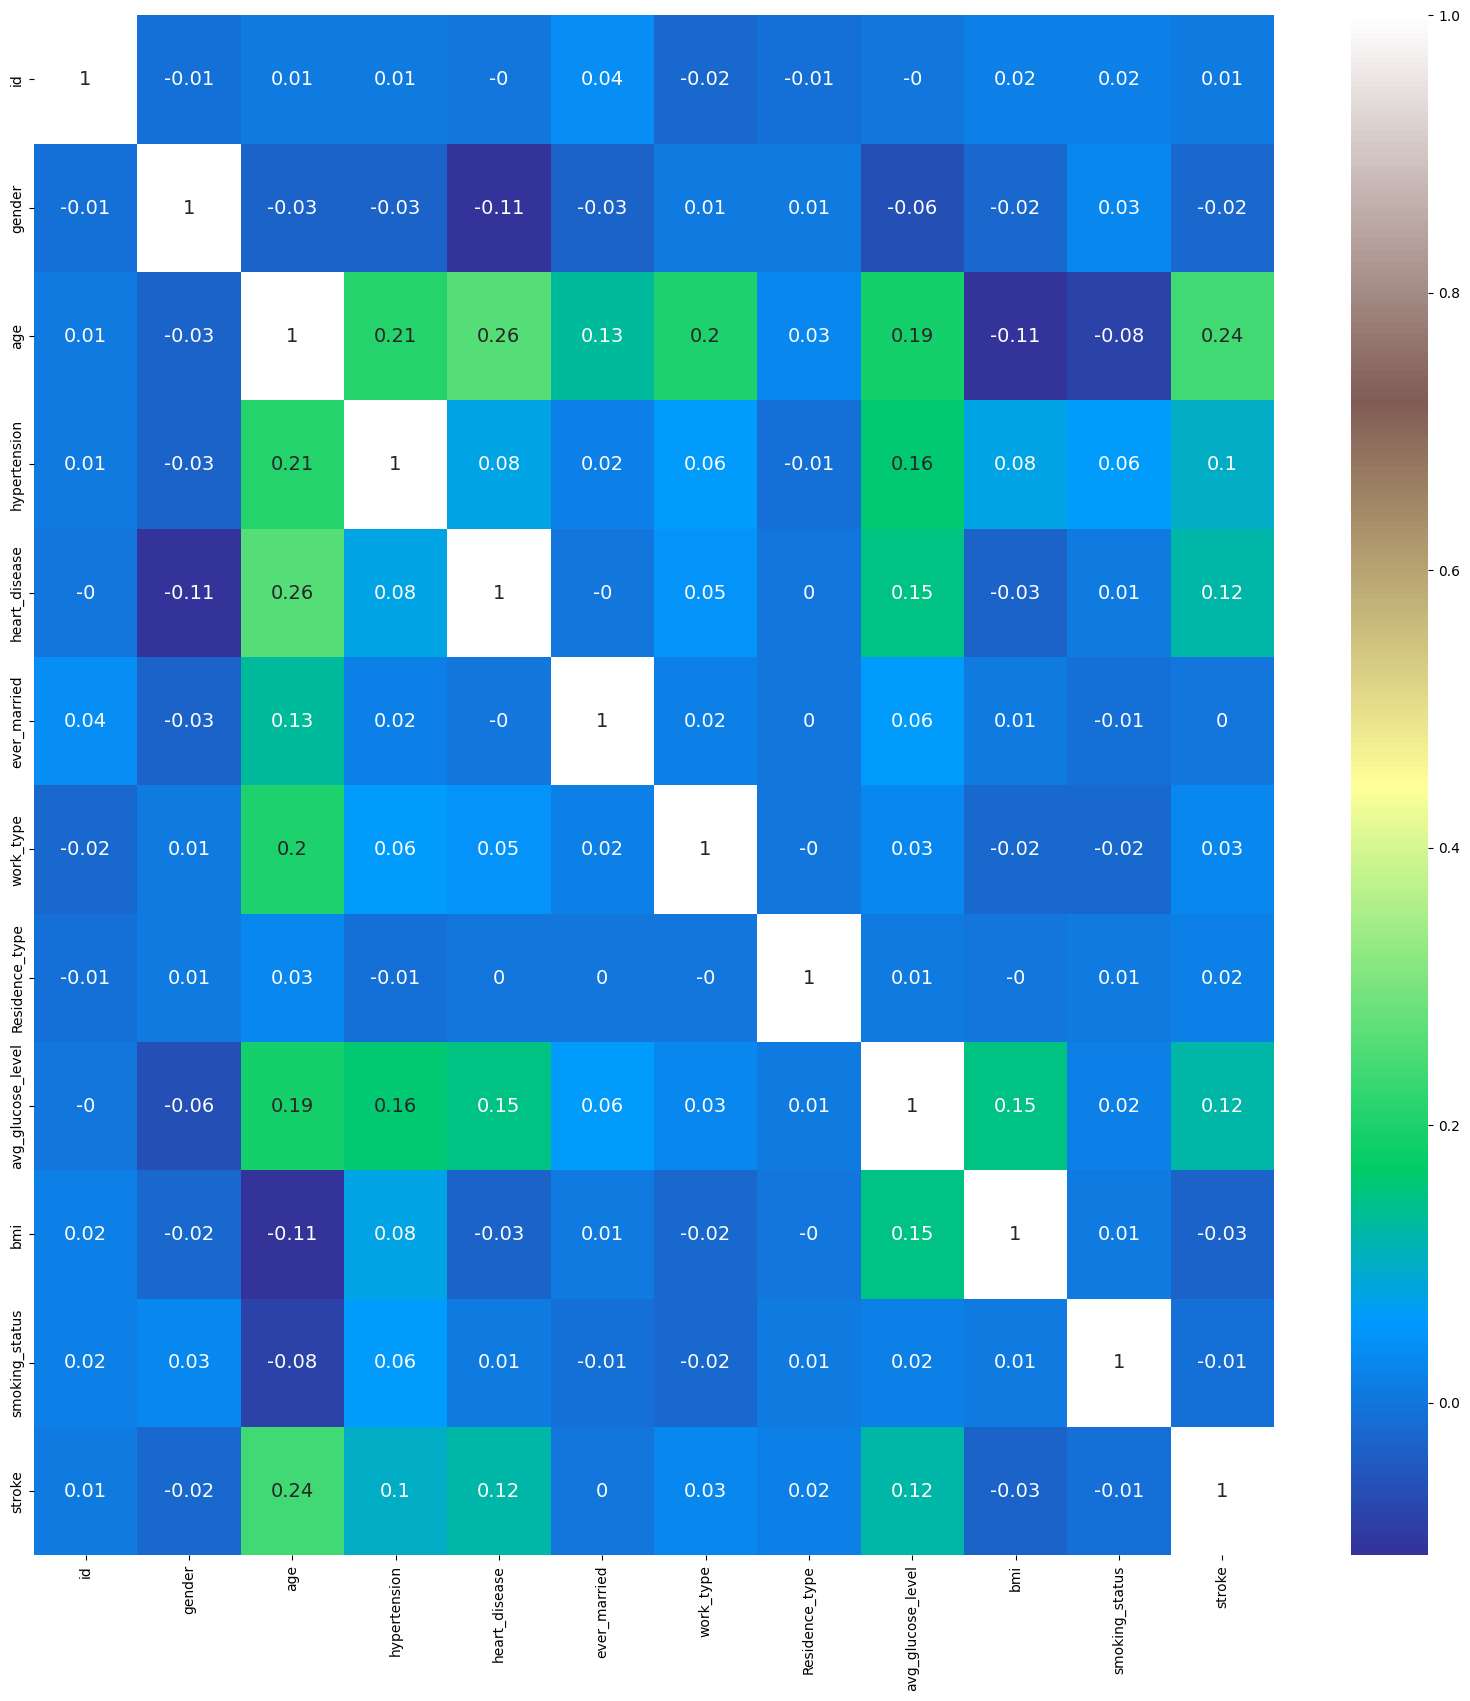

In [363]:
corr_map_df = clean_df
corr_map_df.work_type = corr_map_df['work_type'].astype('category')
corr_map_df.work_type = corr_map_df['work_type'].cat.codes

corr_map_df.smoking_status = corr_map_df['smoking_status'].astype('category')
corr_map_df.smoking_status = corr_map_df['smoking_status'].cat.codes

plt.figure(figsize = (20,20))
sns.heatmap(round(corr_map_df.corr(),2), cmap = "terrain", annot = True, annot_kws = {"size":14})
# hsv terrain jet rainbow tab10 Pastel1 Set3 RdBu viridis inferno plasma cividis magma

without class balance

In [364]:
# %%writefile my_python_file.py
# All Columns to preprocess
to_classify = ['work_type', 'smoking_status' ]
to_robust = ['age', 'avg_glucose_level', 'bmi']
# to_min_max = []
already_processed = ['gender', 'hypertension', 'heart_disease', 'ever_married', 'Residence_type']
# Bench : 'MiscFeature'
select_features = to_classify + to_robust + already_processed # + to_min_max


X = clean_df[select_features]
y = clean_df['stroke']  # Target

r2list = []
rmse_list = []
recall_list = []

# allow more accurate model's performance estimation with more training reps and
# different data splits on a small amount of data, needs to be 1 for prediction tasks.
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, \
        random_state=np.random.randint(1, 20001))

    # Building Pipeline
    preprocessor = ColumnTransformer([
        ('onehot', OneHotEncoder(), to_classify),
        ('robust_scaler', RobustScaler(), to_robust), # RobustScaler/StandardScaler
        # ('minmax', MinMaxScaler(), to_min_max),
    ], remainder='passthrough')  # passthrough/drop

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', LogisticRegression(penalty='l2', class_weight='balanced'))  # Linear Regression model
    ])
    pipeline.fit(X_train, y_train)

    # R^2 Score, not RMSE
    # train_score = pipeline.score(X_train, y_train)
    # test_score = pipeline.score(X_test, y_test)
    r2list.append(pipeline.score(X_test, y_test))
    # print(f"Training_Score: {train_score:.5f}")

    predicted_strokes = pipeline.predict(X_test)
    rmse_list.append(np.sqrt(mean_squared_error(y_test, predicted_strokes)))
    recall_list.append(recall_score(y_test, predicted_strokes))

print(f"# Used features count : {len(select_features)}") #/len(df.columns)
print(f"# Mean Recall: {np.mean(recall_list):.5f}")
print(f"# Mean r2 Test_Score: {np.mean(r2list):.5f}")
# Display RMSE
print(f"# Average prediction error: ~{np.mean(rmse_list):.4f} (RMSE)")


print(f"min/max recall result{[min(recall_list), max(recall_list)]}")

# Used features count : 10
# Mean Recall: 0.72662
# Mean r2 Test_Score: 0.70038
# Average prediction error: ~0.5471 (RMSE)
min/max recall result[0.6470588235294118, 0.8450704225352113]


with undersampling

In [365]:

class_0_df = clean_df[clean_df['stroke'] == 0]
class_1_df = clean_df[clean_df['stroke'] == 1]

undersampled_class_0_data = class_0_df.sample(n=len(class_1_df), random_state=42)
clean_df = pd.concat([undersampled_class_0_data, class_1_df])
clean_df = clean_df.sample(frac=1, random_state=42)

# Now, 'undersampled_data' contains an undersampled version of your original dataset


In [366]:
# %%writefile my_python_file.py
# All Columns to preprocess
to_classify = ['work_type', 'smoking_status' ]
to_robust = ['age', 'avg_glucose_level', 'bmi']
# to_min_max = []
already_processed = ['gender', 'hypertension', 'heart_disease', 'ever_married', 'Residence_type']
# Bench : 'MiscFeature'
select_features = to_classify + to_robust + already_processed # + to_min_max


X = clean_df[select_features]
y = clean_df['stroke']  # Target

r2list = []
rmse_list = []
recall_list = []

# allow more accurate model's performance estimation with more training reps and
# different data splits on a small amount of data, needs to be 1 for prediction tasks.
for i in range(5):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, \
        random_state=np.random.randint(1, 20001))

    # Building Pipeline
    preprocessor = ColumnTransformer([
        ('onehot', OneHotEncoder(), to_classify),
        ('robust_scaler', RobustScaler(), to_robust), # RobustScaler/StandardScaler
        # ('minmax', MinMaxScaler(), to_min_max),
    ], remainder='passthrough')  # passthrough/drop

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', LogisticRegression(penalty='l2'))  # Linear Regression model
    ])
    pipeline.fit(X_train, y_train)

    # R^2 Score, not RMSE
    # train_score = pipeline.score(X_train, y_train)
    # test_score = pipeline.score(X_test, y_test)
    r2list.append(pipeline.score(X_test, y_test))
    # print(f"Training_Score: {train_score:.5f}")

    predicted_strokes = pipeline.predict(X_test)
    rmse_list.append(np.sqrt(mean_squared_error(y_test, predicted_strokes)))
    recall_list.append(recall_score(y_test, predicted_strokes))

print(f"# Used features count : {len(select_features)}") #/len(df.columns)
print(f"# Mean Recall: {np.mean(recall_list):.5f}")
print(f"# Mean r2 Test_Score: {np.mean(r2list):.5f}")
# Display RMSE
print(f"# Average prediction error: ~{np.mean(rmse_list):.4f} (RMSE)")


print(f"min/max recall result{[min(recall_list), max(recall_list)]}")

# Used features count : 10
# Mean Recall: 0.73308
# Mean r2 Test_Score: 0.70470
# Average prediction error: ~0.5422 (RMSE)
min/max recall result[0.6811594202898551, 0.7948717948717948]


With both undersampling and oversampling

In [367]:

class_0_df = clean_df[clean_df['stroke'] == 0]
class_1_df = clean_df[clean_df['stroke'] == 1]

undersampled_class_0_data = class_0_df.sample(n=len(class_1_df)*2, replace=True, random_state=42)
clean_df = pd.concat([class_1_df, undersampled_class_0_data, class_1_df])
clean_df = clean_df.sample(frac=1, random_state=42)

# Now, 'undersampled_data' contains an undersampled version of your original dataset


In [368]:



# %%writefile my_python_file.py
# All Columns to preprocess
to_classify = ['work_type', 'smoking_status' ]
to_robust = ['age', 'avg_glucose_level', 'bmi']
# to_min_max = []
already_processed = ['gender', 'hypertension', 'heart_disease', 'ever_married', 'Residence_type']
# Bench : 'MiscFeature'
select_features = to_classify + to_robust + already_processed # + to_min_max


X = clean_df[select_features]
y = clean_df['stroke']  # Target

r2list = []
rmse_list = []
recall_list = []

# allow more accurate model's performance estimation with more training reps and
# different data splits on a small amount of data, needs to be 1 for prediction tasks.
for i in range(50):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, \
        random_state=np.random.randint(1, 20001))

    # Building Pipeline
    preprocessor = ColumnTransformer([
        ('onehot', OneHotEncoder(), to_classify),
        ('robust_scaler', MinMaxScaler(), to_robust), # RobustScaler/StandardScaler
        # ('minmax', MinMaxScaler(), to_min_max),
    ], remainder='passthrough')  # passthrough/drop

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', LogisticRegression(penalty='l2', max_iter=1000, verbose = 0, n_jobs=4))  # Linear Regression model class_weight='balanced'
    ])
    pipeline.fit(X_train, y_train)

    # R^2 Score, not RMSE
    # train_score = pipeline.score(X_train, y_train)
    # test_score = pipeline.score(X_test, y_test)
    r2list.append(pipeline.score(X_test, y_test))
    # print(f"Training_Score: {train_score:.5f}")

    predicted_strokes = pipeline.predict(X_test)
    rmse_list.append(np.sqrt(mean_squared_error(y_test, predicted_strokes)))
    recall_list.append(recall_score(y_test, predicted_strokes))

print(f"# Used features count : {len(select_features)}") #/len(df.columns)
print(f"# Mean Recall: {np.mean(recall_list):.5f}")
print(f"# Mean r2 Test_Score: {np.mean(r2list):.5f}")
# Display RMSE
print(f"# Average prediction error: ~{np.mean(rmse_list):.4f} (RMSE)")


print(f"min/max recall result{[min(recall_list), max(recall_list)]}")

# Used features count : 10
# Mean Recall: 0.72080
# Mean r2 Test_Score: 0.69771
# Average prediction error: ~0.5494 (RMSE)
min/max recall result[0.6438356164383562, 0.8163265306122449]


One by One Features

In [369]:
# df = pd.read_csv("healthcare-dataset-stroke-data.csv")
# clean_df = df.copy()

# if "Other" in clean_df.gender.value_counts():
#     clean_df = df[df.gender != 'Other']
#     # on va en discuter tkt
#     clean_df = clean_df[clean_df.age>30]
#     # clean_df = clean_df.dropna(axis=0, subset='bmi')

#     # binaires à faire dans la pipeline dans le script bonus
#     clean_df.ever_married = clean_df.ever_married.apply(lambda x : 1 if x == "Yes" else 0)
#     clean_df.Residence_type = clean_df.Residence_type.apply(lambda x : 1 if x == "Urban" else 0)
#     clean_df.gender = clean_df.gender.apply(lambda x : 1 if x == "Female" else 0)
#     clean_df = clean_df.dropna(axis=0, subset='bmi')


In [370]:
# clean_df

Categorical

In [371]:
# %%writefile my_python_file.py
# All Columns to preprocess
# to_classify = ['work_type', 'smoking_status' ]
# to_robust = ['age', 'avg_glucose_level', 'bmi']
# # to_min_max = []
# already_processed = ['gender', 'hypertension', 'heart_disease', 'ever_married', 'Residence_type']
# Bench : 'MiscFeature'
# select_features = ['work_type'] # + to_min_max
select_features = ['smoking_status']

X = clean_df[select_features]
y = clean_df['stroke']  # Target
r2list = []
rmse_list = []
recall_list = []

# allow more accurate model's performance estimation with more training reps and
# different data splits on a small amount of data, needs to be 1 for prediction tasks.
for i in range(50):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, \
        random_state=np.random.randint(1, 20001))

    # Building Pipeline
    preprocessor = ColumnTransformer([
        ('onehot', OneHotEncoder(), select_features),
        # ('robust_scaler', MinMaxScaler(), to_robust), # RobustScaler/StandardScaler
        # ('minmax', MinMaxScaler(), to_min_max),
    ], remainder='passthrough')  # passthrough/drop

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', LogisticRegression(penalty='l2', max_iter=100, class_weight='balanced'))  # Linear Regression model class_weight='balanced' , n_jobs=4
    ])
    # print(f"{X_train, y_train}")
    pipeline.fit(X_train, y_train)
    r2list.append(pipeline.score(X_test, y_test))

    predicted_strokes = pipeline.predict(X_test)
    rmse_list.append(np.sqrt(mean_squared_error(y_test, predicted_strokes)))
    recall_list.append(recall_score(y_test, predicted_strokes))

print(f"# Used features count : {len(select_features)}") #/len(df.columns)
print(f"# Mean Recall: {np.mean(recall_list):.5f}")
print(f"# Mean r2 Test_Score: {np.mean(r2list):.5f}")
# Display RMSE
print(f"# Average prediction error: ~{np.mean(rmse_list):.4f} (RMSE)")


print(f"min/max recall result{[min(recall_list), max(recall_list)]}")

# Used features count : 1
# Mean Recall: 0.59796
# Mean r2 Test_Score: 0.52970
# Average prediction error: ~0.6856 (RMSE)
min/max recall result[0.2323943661971831, 0.8592592592592593]


First attempts :

work_type : 0.42

smoking_status : 0.49


Numericals

In [372]:

# %%writefile my_python_file.py
# All Columns to preprocess
# to_classify = ['work_type', 'smoking_status' ]
# to_robust = ['age', 'avg_glucose_level', 'bmi']
# # to_min_max = []
# already_processed = ['gender', 'hypertension', 'heart_disease', 'ever_married', 'Residence_type']
# Bench : 'MiscFeature'
# select_features = ['work_type'] # + to_min_max
select_features = ['bmi']

X = clean_df[select_features]
y = clean_df['stroke']  # Target
r2list = []
rmse_list = []
recall_list = []

# allow more accurate model's performance estimation with more training reps and
# different data splits on a small amount of data, needs to be 1 for prediction tasks.
for i in range(50):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, \
        random_state=np.random.randint(1, 20001))

    # Building Pipeline
    preprocessor = ColumnTransformer([
        ('onehot', MinMaxScaler(), select_features),
        # ('robust_scaler', MinMaxScaler(), to_robust), # RobustScaler/StandardScaler
        # ('minmax', MinMaxScaler(), to_min_max),
    ], remainder='passthrough')  # passthrough/drop

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', LogisticRegression(penalty='l2', max_iter=100, class_weight='balanced'))  # Linear Regression model class_weight='balanced' , n_jobs=4
    ])
    # print(f"{X_train, y_train}")
    pipeline.fit(X_train, y_train)
    r2list.append(pipeline.score(X_test, y_test))

    predicted_strokes = pipeline.predict(X_test)
    rmse_list.append(np.sqrt(mean_squared_error(y_test, predicted_strokes)))
    recall_list.append(recall_score(y_test, predicted_strokes))

print(f"# Used features count : {len(select_features)}") #/len(df.columns)
print(f"# Mean Recall: {np.mean(recall_list):.5f}")
print(f"# Mean r2 Test_Score: {np.mean(r2list):.5f}")
# Display RMSE
print(f"# Average prediction error: ~{np.mean(rmse_list):.4f} (RMSE)")


print(f"min/max recall result{[min(recall_list), max(recall_list)]}")

# Used features count : 1
# Mean Recall: 0.57517
# Mean r2 Test_Score: 0.51616
# Average prediction error: ~0.6952 (RMSE)
min/max recall result[0.3087248322147651, 0.6944444444444444]


First attempts :

age : 0.67

avg_glucose_level : 0.42

bmi : 0.55574


Binaries

In [373]:
# %%writefile my_python_file.py
# All Columns to preprocess
# to_classify = ['work_type', 'smoking_status' ]
# to_robust = ['age', 'avg_glucose_level', 'bmi']
# # to_min_max = []
# already_processed = ['gender', 'hypertension', 'heart_disease', 'ever_married', 'Residence_type']
# Bench : 'MiscFeature'
# select_features = ['work_type'] # + to_min_max
select_features = ['Residence_type']

X = clean_df[select_features]
y = clean_df['stroke']  # Target
r2list = []
rmse_list = []
recall_list = []

# allow more accurate model's performance estimation with more training reps and
# different data splits on a small amount of data, needs to be 1 for prediction tasks.
for i in range(50):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, \
        random_state=np.random.randint(1, 20001))

    # Building Pipeline
    preprocessor = ColumnTransformer([
        ('onehot', OneHotEncoder(), select_features),
        # ('robust_scaler', MinMaxScaler(), to_robust), # RobustScaler/StandardScaler
        # ('minmax', MinMaxScaler(), to_min_max),
    ], remainder='passthrough')  # passthrough/drop

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', LogisticRegression(penalty='l2', max_iter=100, class_weight='balanced'))  # Linear Regression model class_weight='balanced' , n_jobs=4
    ])
    # print(f"{X_train, y_train}")
    pipeline.fit(X_train, y_train)
    r2list.append(pipeline.score(X_test, y_test))

    predicted_strokes = pipeline.predict(X_test)
    rmse_list.append(np.sqrt(mean_squared_error(y_test, predicted_strokes)))
    recall_list.append(recall_score(y_test, predicted_strokes))

print(f"# Used features count : {len(select_features)}") #/len(df.columns)
print(f"# Mean Recall: {np.mean(recall_list):.5f}")
print(f"# Mean r2 Test_Score: {np.mean(r2list):.5f}")
# Display RMSE
print(f"# Average prediction error: ~{np.mean(rmse_list):.4f} (RMSE)")


print(f"min/max recall result{[min(recall_list), max(recall_list)]}")

# Used features count : 1
# Mean Recall: 0.52699
# Mean r2 Test_Score: 0.50229
# Average prediction error: ~0.7053 (RMSE)
min/max recall result[0.4014084507042254, 0.5945945945945946]


First attempts :

gender : 0.42

hypertension : 0.28

heart_disease : 0.19

ever_married : 0.42845

Residence_type : 0.49


work_type : 0.42

smoking_status : 0.49





age : 0.67

avg_glucose_level : 0.42

bmi : 0.55574




gender : 0.42

hypertension : 0.28

heart_disease : 0.19

ever_married : 0.42845

Residence_type : 0.49

In [374]:
features_to_keep = ['age', 'bmi', 'smoking_status', 'Residence_type']


Regression with proper features

In [375]:
# %%writefile my_python_file.py
# All Columns to preprocess
to_classify = ['smoking_status' ]
to_robust = ['age', 'bmi']
# to_min_max = []
already_processed = ['Residence_type']
# Bench : 'MiscFeature'
select_features = to_classify + to_robust + already_processed # + to_min_max


X = clean_df[select_features]
y = clean_df['stroke']  # Target

r2list = []
rmse_list = []
recall_list = []

# allow more accurate model's performance estimation with more training reps and
# different data splits on a small amount of data, needs to be 1 for prediction tasks.
for i in range(50):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, \
        random_state=np.random.randint(1, 20001))

    # Building Pipeline
    preprocessor = ColumnTransformer([
        ('onehot', OneHotEncoder(), to_classify),
        ('robust_scaler', MinMaxScaler(), to_robust), # RobustScaler/StandardScaler
        # ('minmax', MinMaxScaler(), to_min_max),
    ], remainder='passthrough')  # passthrough/drop

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', LogisticRegression(penalty='l2', max_iter=1000, class_weight='balanced', n_jobs=8))  # Linear Regression model class_weight='balanced'
    ])
    pipeline.fit(X_train, y_train)

    # R^2 Score, not RMSE
    # train_score = pipeline.score(X_train, y_train)
    # test_score = pipeline.score(X_test, y_test)
    r2list.append(pipeline.score(X_test, y_test))
    # print(f"Training_Score: {train_score:.5f}")

    predicted_strokes = pipeline.predict(X_test)
    rmse_list.append(np.sqrt(mean_squared_error(y_test, predicted_strokes)))
    recall_list.append(recall_score(y_test, predicted_strokes))

print(f"# Used features count : {len(select_features) } - {select_features}") #/len(df.columns)
print(f"# Mean Recall: {np.mean(recall_list):.5f}")
print(f"# Mean r2 Test_Score: {np.mean(r2list):.5f}")
# Display RMSE
print(f"# Average prediction error: ~{np.mean(rmse_list):.4f} (RMSE)")


print(f"min/max recall result{[min(recall_list), max(recall_list)]}")

# Used features count : 4 - ['smoking_status', 'age', 'bmi', 'Residence_type']
# Mean Recall: 0.71319
# Mean r2 Test_Score: 0.68976
# Average prediction error: ~0.5566 (RMSE)
min/max recall result[0.6026490066225165, 0.8040540540540541]


In [376]:
# %%writefile my_python_file.py
# All Columns to preprocess
to_robust = ['age', 'bmi']
# to_min_max = []
# Bench : 'MiscFeature'
select_features = to_robust # + to_min_max


X = clean_df[select_features]
y = clean_df['stroke']  # Target

r2list = []
rmse_list = []
recall_list = []

# allow more accurate model's performance estimation with more training reps and
# different data splits on a small amount of data, needs to be 1 for prediction tasks.
for i in range(50):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, \
        random_state=np.random.randint(1, 20001))

    # Building Pipeline
    preprocessor = ColumnTransformer([
        ('robust_scaler', MinMaxScaler(), to_robust) # RobustScaler/StandardScaler
        # ('minmax', MinMaxScaler(), to_min_max),
    ], remainder='passthrough')  # passthrough/drop

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', LogisticRegression(penalty='l2', max_iter=1000, class_weight='balanced', n_jobs=8))  # Linear Regression model class_weight='balanced'
    ])
    pipeline.fit(X_train, y_train)

    # R^2 Score, not RMSE
    # train_score = pipeline.score(X_train, y_train)
    # test_score = pipeline.score(X_test, y_test)
    r2list.append(pipeline.score(X_test, y_test))
    # print(f"Training_Score: {train_score:.5f}")

    predicted_strokes = pipeline.predict(X_test)
    rmse_list.append(np.sqrt(mean_squared_error(y_test, predicted_strokes)))
    recall_list.append(recall_score(y_test, predicted_strokes))

print(f"# Used features count : {len(select_features) } - {select_features}") #/len(df.columns)
print(f"# Mean Recall: {np.mean(recall_list):.5f}")
print(f"# Mean r2 Test_Score: {np.mean(r2list):.5f}")
# Display RMSE
print(f"# Average prediction error: ~{np.mean(rmse_list):.4f} (RMSE)")


print(f"min/max recall result{[min(recall_list), max(recall_list)]}")

# Used features count : 2 - ['age', 'bmi']
# Mean Recall: 0.69861
# Mean r2 Test_Score: 0.68606
# Average prediction error: ~0.5599 (RMSE)
min/max recall result[0.6118421052631579, 0.7681159420289855]


# RandomForestClassifier

In [377]:

to_classify = ['smoking_status' ]
to_robust = ['age', 'bmi']
already_processed = ['Residence_type', 'gender']


select_features = to_classify + to_robust + already_processed # + to_min_max

X = clean_df[select_features]
y = clean_df['stroke']  # Target

r2list = []
rmse_list = []
recall_list = []

# allow more accurate model's performance estimation with more training reps and
# different data splits on a small amount of data, needs to be 1 for prediction tasks.
for i in range(5):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, \
        random_state=np.random.randint(1, 20001))

    # Building Pipeline
    preprocessor = ColumnTransformer([
        ('onehot', OneHotEncoder(), to_classify),
        ('robust_scaler', MinMaxScaler(), to_robust), # RobustScaler/StandardScaler
        # ('minmax', MinMaxScaler(), to_min_max),
    ], remainder='passthrough')  # passthrough/drop

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('random_forest', RandomForestClassifier(max_depth=1, n_estimators=1000, random_state=0, class_weight='balanced'))
        # ('regressor', LogisticRegression(penalty='l2', max_iter=1000, class_weight='balanced', n_jobs=8))  # Linear Regression model class_weight='balanced'
    ])
    pipeline.fit(X_train, y_train)

    # R^2 Score, not RMSE
    # train_score = pipeline.score(X_train, y_train)
    # test_score = pipeline.score(X_test, y_test)
    r2list.append(pipeline.score(X_test, y_test))
    # print(f"Training_Score: {train_score:.5f}")

    predicted_strokes = pipeline.predict(X_test)
    rmse_list.append(np.sqrt(mean_squared_error(y_test, predicted_strokes)))
    recall_list.append(recall_score(y_test, predicted_strokes))

print(f"# Used features count : {len(select_features) } - {select_features}") #/len(df.columns)
print(f"# Mean Recall: {np.mean(recall_list):.5f}")
print(f"# Mean r2 Test_Score: {np.mean(r2list):.5f}")
# Display RMSE
print(f"# Average prediction error: ~{np.mean(rmse_list):.4f} (RMSE)")


print(f"min/max recall result{[min(recall_list), max(recall_list)]}")

# Used features count : 5 - ['smoking_status', 'age', 'bmi', 'Residence_type', 'gender']
# Mean Recall: 0.83361
# Mean r2 Test_Score: 0.70101
# Average prediction error: ~0.5466 (RMSE)
min/max recall result[0.7986577181208053, 0.8662420382165605]


In [378]:
df = pd.read_csv("healthcare-dataset-stroke-data.csv")
clean_df = df.copy()

if "Other" in clean_df.gender.value_counts():
    clean_df = df[df.gender != 'Other']
    # on va en discuter tkt
    clean_df = clean_df[clean_df.age>30]
    # clean_df = clean_df.dropna(axis=0, subset='bmi')

    # binaires à faire dans la pipeline dans le script bonus
    clean_df.ever_married = clean_df.ever_married.apply(lambda x : 1 if x == "Yes" else 0)
    clean_df.Residence_type = clean_df.Residence_type.apply(lambda x : 1 if x == "Urban" else 0)
    clean_df.gender = clean_df.gender.apply(lambda x : 1 if x == "Female" else 0)
    # clean_df.bmi = clean_df.bmi.apply(lambda x : x if isinstance(x, float) else 0)
    clean_df.bmi.fillna(0, inplace=True)
    clean_df = clean_df[clean_df.bmi <= 60]


In [379]:

to_classify = ['smoking_status' ]
to_robust = ['age', 'bmi']
already_processed = ['Residence_type', 'gender']

select_features = to_classify + to_robust + already_processed # + to_min_max

X = clean_df[select_features]
y = clean_df['stroke']  # Target

r2list = []
rmse_list = []
recall_list = []

# allow more accurate model's performance estimation with more training reps and
# different data splits on a small amount of data, needs to be 1 for prediction tasks.
for i in range(1000):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, \
        random_state=np.random.randint(1, 20001))

    # Building Pipeline
    preprocessor = ColumnTransformer([
        ('onehot', OneHotEncoder(), to_classify),
        ('robust_scaler', MinMaxScaler(), to_robust), # RobustScaler/StandardScaler
        # ('minmax', MinMaxScaler(), to_min_max),
    ], remainder='passthrough')  # passthrough/drop

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('random_forest', DecisionTreeClassifier(max_depth=2, random_state=0, class_weight='balanced')) #class_weight
        # ('regressor', LogisticRegression(penalty='l2', max_iter=1000, class_weight='balanced', n_jobs=8))  # Linear Regression model class_weight='balanced'
    ])
    pipeline.fit(X_train, y_train)

    r2list.append(pipeline.score(X_test, y_test))

    predicted_strokes = pipeline.predict(X_test)


    rmse_list.append(np.sqrt(mean_squared_error(y_test, predicted_strokes)))
    recall_list.append(recall_score(y_test, predicted_strokes))
    if recall_list[-1] == max(recall_list) :
        joblib.dump(pipeline, 'app/app_model/model.pkl')

print(f"# Used features count : {len(select_features) } - {select_features}") #/len(df.columns)
print(f"# Mean Recall: {np.mean(recall_list):.5f}")
print(f"# Mean r2 Test_Score: {np.mean(r2list):.5f}")
# Display RMSE
print(f"# Average prediction error: ~{np.mean(rmse_list):.4f} (RMSE)")


print(f"min/max recall result{[min(recall_list), max(recall_list)]}")

# Used features count : 5 - ['smoking_status', 'age', 'bmi', 'Residence_type', 'gender']
# Mean Recall: 0.78950
# Mean r2 Test_Score: 0.60940
# Average prediction error: ~0.6218 (RMSE)
min/max recall result[0.42857142857142855, 0.96]


In [380]:
# df = pd.read_csv("healthcare-dataset-stroke-data.csv")
# clean_df = df.copy()

# if "Other" in clean_df.gender.value_counts():
#     clean_df = df[df.gender != 'Other']
#     # on va en discuter tkt
#     clean_df = clean_df[clean_df.age>30]
#     # clean_df = clean_df.dropna(axis=0, subset='bmi')

#     # binaires à faire dans la pipeline dans le script bonus
#     clean_df.ever_married = clean_df.ever_married.apply(lambda x : 1 if x == "Yes" else 0)
#     clean_df.Residence_type = clean_df.Residence_type.apply(lambda x : 1 if x == "Urban" else 0)
#     clean_df.gender = clean_df.gender.apply(lambda x : 1 if x == "Female" else 0)
#     # clean_df.bmi = clean_df.bmi.apply(lambda x : x if isinstance(x, float) else 0)
#     clean_df = clean_df[clean_df.bmi <= 60]


In [381]:

to_classify = ['smoking_status' ]
to_robust = ['age', 'bmi']
already_processed = ['Residence_type', 'gender']

select_features = to_classify + to_robust + already_processed # + to_min_max

X = clean_df[select_features]
y = clean_df['stroke']  # Target

r2list = []
rmse_list = []
recall_list = []

# allow more accurate model's performance estimation with more training reps and
# different data splits on a small amount of data, needs to be 1 for prediction tasks.
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, \
        random_state=np.random.randint(1, 20001))

    # Building Pipeline
    preprocessor = ColumnTransformer([
        ('onehot', OneHotEncoder(), to_classify),
        ('robust_scaler', MinMaxScaler(), to_robust), # RobustScaler/StandardScaler
        # ('minmax', MinMaxScaler(), to_min_max),
    ], remainder='passthrough')  # passthrough/drop

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('random_forest', KNeighborsClassifier(n_neighbors = 20, algorithm='kd_tree')) #class_weight
        # ('regressor', LogisticRegression(penalty='l2', max_iter=1000, class_weight='balanced', n_jobs=8))  # Linear Regression model class_weight='balanced'
    ])
    pipeline.fit(X_train, y_train)

    r2list.append(pipeline.score(X_test, y_test))

    predicted_strokes = pipeline.predict(X_test)


    rmse_list.append(np.sqrt(mean_squared_error(y_test, predicted_strokes)))
    recall_list.append(recall_score(y_test, predicted_strokes))
    if recall_list[-1] == max(recall_list) :
        joblib.dump(pipeline, 'app/app_model/model.pkl')

print(f"# Used features count : {len(select_features) } - {select_features}") #/len(df.columns)
print(f"# Mean Recall: {np.mean(recall_list):.5f}")
print(f"# Mean r2 Test_Score: {np.mean(r2list):.5f}")
# Display RMSE
print(f"# Average prediction error: ~{np.mean(rmse_list):.4f} (RMSE)")

print(f"min/max recall result{[min(recall_list), max(recall_list)]}")

# Used features count : 5 - ['smoking_status', 'age', 'bmi', 'Residence_type', 'gender']
# Mean Recall: 0.00000
# Mean r2 Test_Score: 0.93283
# Average prediction error: ~0.2590 (RMSE)
min/max recall result[0.0, 0.0]


1. Imports

In [382]:
df = pd.read_csv("healthcare-dataset-stroke-data.csv")

In [383]:
df.head(5)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [384]:
df.ever_married.value_counts()

ever_married
Yes    3353
No     1757
Name: count, dtype: int64

In [385]:
df.gender.value_counts()

gender
Female    2994
Male      2115
Other        1
Name: count, dtype: int64

2. Data Analysis

In [386]:
df.describe().applymap(lambda x: round(x, 3))

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000,5110.000,5110.000,5110.000,5110.000,4909.000,5110.000
mean,36517.829,43.227,0.097,0.054,106.148,28.893,0.049
std,21161.722,22.613,0.297,0.226,45.284,7.854,0.215
min,67.000,0.080,0.000,0.000,55.120,10.300,0.000
25%,17741.250,25.000,0.000,0.000,77.245,23.500,0.000
50%,36932.000,45.000,0.000,0.000,91.885,28.100,0.000
75%,54682.000,61.000,0.000,0.000,114.090,33.100,0.000
max,72940.000,82.000,1.000,1.000,271.740,97.600,1.000


In [387]:
# plt.figure(figsize = (50,50))
# sns.heatmap(round(df.corr(),2), cmap = "coolwarm", annot = True, annot_kws = {"size":12})

In [388]:
# plt.figure(figsize=(15,4))

# sns.regplot(x='age', y='stroke', data=df.sample(100, random_state=9), ci=95)

In [389]:
df.nunique()[df.nunique() == 2]

hypertension      2
heart_disease     2
ever_married      2
Residence_type    2
stroke            2
dtype: int64

In [390]:
df.drop(columns=['id']).nunique()[df.nunique() != 2]

gender                  3
age                   104
work_type               5
avg_glucose_level    3979
bmi                   418
smoking_status          4
dtype: int64

In [391]:
# Display numerics columns
df.select_dtypes(include=['int64', 'float64'])

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
0,9046,67.0,0,1,228.69,36.6,1
1,51676,61.0,0,0,202.21,NaN,1
2,31112,80.0,0,1,105.92,32.5,1
3,60182,49.0,0,0,171.23,34.4,1
4,1665,79.0,1,0,174.12,24.0,1
...,...,...,...,...,...,...,...
5105,18234,80.0,1,0,83.75,NaN,0
5106,44873,81.0,0,0,125.20,40.0,0
5107,19723,35.0,0,0,82.99,30.6,0
5108,37544,51.0,0,0,166.29,25.6,0


In [392]:
# Display Objects columns
df.select_dtypes(include=['O'])

,gender,ever_married,work_type,Residence_type,smoking_status
0,Male,Yes,Private,Urban,formerly smoked
1,Female,Yes,Self-employed,Rural,never smoked
2,Male,Yes,Private,Rural,never smoked
3,Female,Yes,Private,Urban,smokes
4,Female,Yes,Self-employed,Rural,never smoked
...,...,...,...,...,...
5105,Female,Yes,Private,Urban,never smoked
5106,Female,Yes,Self-employed,Urban,never smoked
5107,Female,Yes,Self-employed,Rural,never smoked
5108,Male,Yes,Private,Rural,formerly smoked


In [393]:
# curves_step = [1, 200, 300, 400, 500, 600, 650, 712]
# train_sizes, train_scores, test_scores = learning_curve(
#     estimator=LogisticRegression(), X=X, y=y, train_sizes=curves_step, cv=5)
# train_scores_mean = np.mean(train_scores, axis=1)
# test_scores_mean = np.mean(test_scores, axis=1)
# plt.plot(train_sizes, train_scores_mean, label = 'Training score')
# plt.plot(train_sizes, test_scores_mean, label = 'Test score')
# plt.ylabel('r2 score', fontsize = 14)
# plt.xlabel('Training set size', fontsize = 14)
# plt.title('Learning curves', fontsize = 18, y = 1.03)
# plt.legend()

In [394]:
# df.shape
# df.isna()
percent_missing = df.isnull().sum() * 100 / len(df)
missing_value_df = pd.DataFrame({'column_name': df.columns,
                                 'percent_missing': percent_missing})
missing_value_df.sort_values('percent_missing', inplace=True)
percent_missing = df.isnull().sum() * 100 / len(df)
percent_missing.sort_values(ascending=False).head(15)


bmi                  3.933464
id                   0.000000
gender               0.000000
age                  0.000000
hypertension         0.000000
heart_disease        0.000000
ever_married         0.000000
work_type            0.000000
Residence_type       0.000000
avg_glucose_level    0.000000
smoking_status       0.000000
stroke               0.000000
dtype: float64

In [395]:
# df.gender.value_counts()
df.age.min()


0.08

In [396]:
df.age.count()

5110

En outlier sur la colonne age on à un avc recensé à 2 ans et un autre à 16 ans 

In [397]:
df[df.age<30].stroke.value_counts()

stroke
0    1513
1       2
Name: count, dtype: int64

In [398]:
df[df.age<39].stroke.value_counts()

stroke
0    2094
1       5
Name: count, dtype: int64

In [399]:
# sns.histplot(x=df.stroke, y=df.age) with stroke in hue
# sns.histplot(df.age.value_counts, df.age.value_counts.index)

In [400]:
df.avg_glucose_level.min()


55.12

In [401]:
df.avg_glucose_level.max()

271.74

In [402]:
df.bmi.isna().value_counts()

bmi
False    4909
True      201
Name: count, dtype: int64

In [403]:
df.smoking_status.value_counts()

smoking_status
never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: count, dtype: int64

In [404]:
df.stroke.value_counts()

stroke
0    4861
1     249
Name: count, dtype: int64

In [405]:
df.work_type

0             Private
1       Self-employed
2             Private
3             Private
4       Self-employed
            ...      
5105          Private
5106    Self-employed
5107    Self-employed
5108          Private
5109         Govt_job
Name: work_type, Length: 5110, dtype: object

3. Feature Engineering

In [406]:
clean_df = df[df.gender != 'Other']
# on va en discuter tkt
clean_df = clean_df[clean_df.age>30]

In [407]:
df.gender.value_counts()

gender
Female    2994
Male      2115
Other        1
Name: count, dtype: int64

In [408]:
df.ever_married = df.ever_married.apply(lambda x : 1 if x == "Yes" else 0)


In [409]:
df.Residence_type.value_counts()
df.Residence_type = df.Residence_type.apply(lambda x : 1 if x == "Urban" else 0)
df.Residence_type.value_counts()


Residence_type
1    2596
0    2514
Name: count, dtype: int64

In [410]:
df

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,1,Private,1,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,1,Self-employed,0,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,1,Private,0,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,1,Private,1,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,1,Self-employed,0,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,1,Private,1,83.75,NaN,never smoked,0
5106,44873,Female,81.0,0,0,1,Self-employed,1,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,1,Self-employed,0,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,1,Private,0,166.29,25.6,formerly smoked,0


In [411]:
label_encoder = LabelEncoder()
label_encoder.fit_transform(df.work_type)


array([2, 3, 2, ..., 3, 2, 0])

In [412]:
# from sklearn.preprocessing import OneHotEncoder

# categorical_column_reshaped = df.work_type.values.reshape(-1, 1)

# OneHotEncoder(sparse_output=False).fit_transform(categorical_column_reshaped)

In [413]:
df.work_type[0:20]

0           Private
1     Self-employed
2           Private
3           Private
4     Self-employed
5           Private
6           Private
7           Private
8           Private
9           Private
10          Private
11         Govt_job
12          Private
13          Private
14          Private
15    Self-employed
16          Private
17          Private
18          Private
19         Govt_job
Name: work_type, dtype: object

In [414]:
df.work_type.value_counts()

work_type
Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: count, dtype: int64

In [415]:

# CentralAir_encoder = OneHotEncoder(sparse=False, drop='if_binary', categories=[['Private', 'Self-employed', 'children', 'Govt_job', 'Never_worked' ]]) # Instanciate encoder
# df['CentralAir'] = CentralAir_encoder.fit_transform(df.work_type) # Fit encoder and tranform

In [416]:
# df = pd.read_csv("healthcare-dataset-stroke-data.csv")
# clean_df = df.copy()

# if "Other" in clean_df.gender.value_counts():
#     clean_df = df[df.gender != 'Other']
#     # on va en discuter tkt
#     clean_df = clean_df[clean_df.age>30]
#     # clean_df = clean_df.dropna(axis=0, subset='bmi')

#     # binaires à faire dans la pipeline dans le script bonus
#     clean_df.ever_married = clean_df.ever_married.apply(lambda x : 1 if x == "Yes" else 0)
#     clean_df.Residence_type = clean_df.Residence_type.apply(lambda x : 1 if x == "Urban" else 0)
#     clean_df.gender = clean_df.gender.apply(lambda x : 1 if x == "Female" else 0)
#     # clean_df.bmi = clean_df.bmi.apply(lambda x : x if isinstance(x, float) else 0)
#     clean_df.bmi.fillna(0, inplace=True)
#     clean_df = clean_df[clean_df.bmi <= 60]

df = pd.read_csv("healthcare-dataset-stroke-data.csv")
clean_df = df.copy()

if "Other" in clean_df.gender.value_counts():
    clean_df = df[df.gender != 'Other']
    # on va en discuter tkt
    clean_df = clean_df[clean_df.age>30]


    # clean_df = clean_df.dropna(axis=0, subset='bmi')

    # binaires à faire dans la pipeline dans le script bonus
    clean_df.ever_married = clean_df.ever_married.apply(lambda x : 1 if x == "Yes" else 0)
    clean_df.Residence_type = clean_df.Residence_type.apply(lambda x : 1 if x == "Urban" else 0)
    clean_df.gender = clean_df.gender.apply(lambda x : 1 if x == "Female" else 0)



    clean_df['bmi'] = clean_df['bmi'].fillna(df['bmi'].median())
    # from Sacia
    clean_df = clean_df[clean_df.bmi <= 60]

    # A CHANGER ABSOLUMENT
    clean_df.bmi.fillna(0, inplace=True)


{'bodies': [<matplotlib.collections.PolyCollection at 0x7feb92159520>],
 'cmaxes': <matplotlib.collections.LineCollection at 0x7feb92159430>,
 'cmins': <matplotlib.collections.LineCollection at 0x7feb92159ac0>,
 'cbars': <matplotlib.collections.LineCollection at 0x7feb92159e20>}

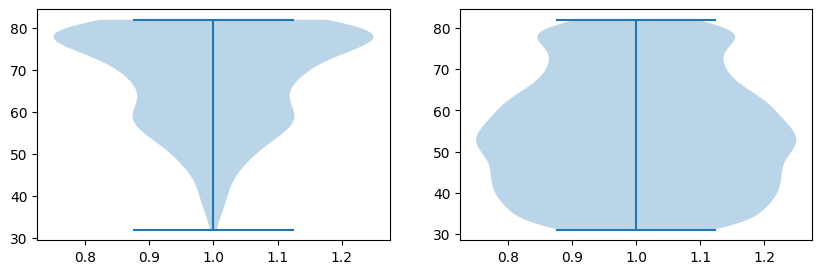

In [417]:
clean_df
f = plt.figure(figsize=(10,3))
ax = f.add_subplot(121)
plt.violinplot(clean_df.age[clean_df.stroke == 1])
ax2 = f.add_subplot(122)
plt.violinplot(clean_df.age[clean_df.stroke != 1])

{'bodies': [<matplotlib.collections.PolyCollection at 0x7feb9106c7f0>],
 'cmaxes': <matplotlib.collections.LineCollection at 0x7feb9106c700>,
 'cmins': <matplotlib.collections.LineCollection at 0x7feb9106cd90>,
 'cbars': <matplotlib.collections.LineCollection at 0x7feb90ffc130>}

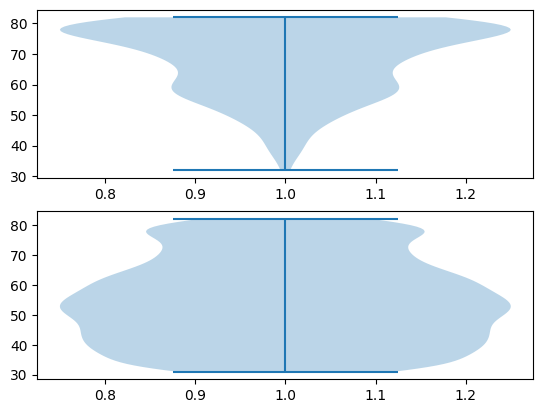

In [418]:
fig, axs = plt.subplots(2)
axs[0].violinplot(clean_df.age[clean_df.stroke == 1])
axs[1].violinplot(clean_df.age[clean_df.stroke != 1])

In [419]:
clean_df

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,0,67.0,0,1,1,Private,1,228.69,36.6,formerly smoked,1
1,51676,1,61.0,0,0,1,Self-employed,0,202.21,28.1,never smoked,1
2,31112,0,80.0,0,1,1,Private,0,105.92,32.5,never smoked,1
3,60182,1,49.0,0,0,1,Private,1,171.23,34.4,smokes,1
4,1665,1,79.0,1,0,1,Self-employed,0,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,1,80.0,1,0,1,Private,1,83.75,28.1,never smoked,0
5106,44873,1,81.0,0,0,1,Self-employed,1,125.20,40.0,never smoked,0
5107,19723,1,35.0,0,0,1,Self-employed,0,82.99,30.6,never smoked,0
5108,37544,0,51.0,0,0,1,Private,0,166.29,25.6,formerly smoked,0


In [420]:
clean_df.gender.value_counts()

gender
1    2099
0    1432
Name: count, dtype: int64

{'bodies': [<matplotlib.collections.PolyCollection at 0x7feb90f55a60>],
 'cmaxes': <matplotlib.collections.LineCollection at 0x7feb90f55970>,
 'cmins': <matplotlib.collections.LineCollection at 0x7feb90f46af0>,
 'cbars': <matplotlib.collections.LineCollection at 0x7feb90f673a0>}

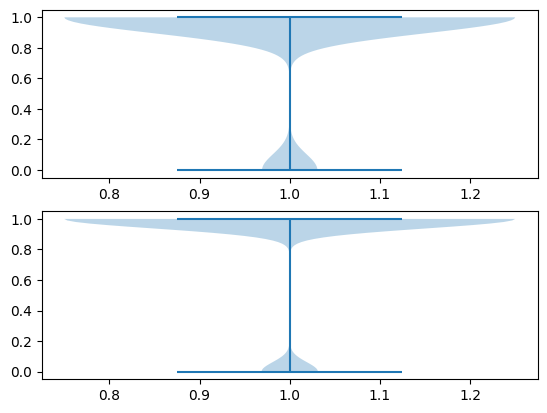

In [421]:
fig, axs = plt.subplots(2)
axs[0].violinplot(clean_df.ever_married[clean_df.stroke == 1])
axs[1].violinplot(clean_df.ever_married[clean_df.stroke != 1])

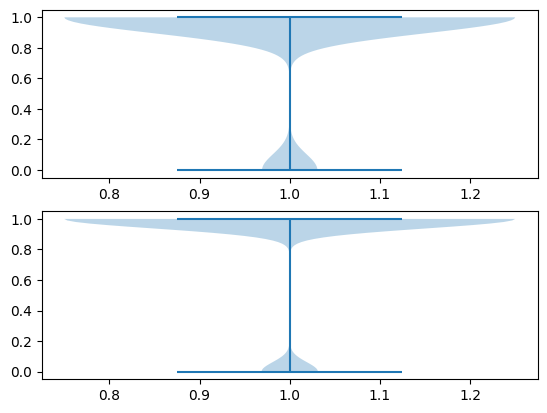

In [422]:


fig, axs = plt.subplots(2)
violin1 = axs[0].violinplot(clean_df.ever_married[clean_df.stroke == 1])
violin2 = axs[1].violinplot(clean_df.ever_married[clean_df.stroke != 1])


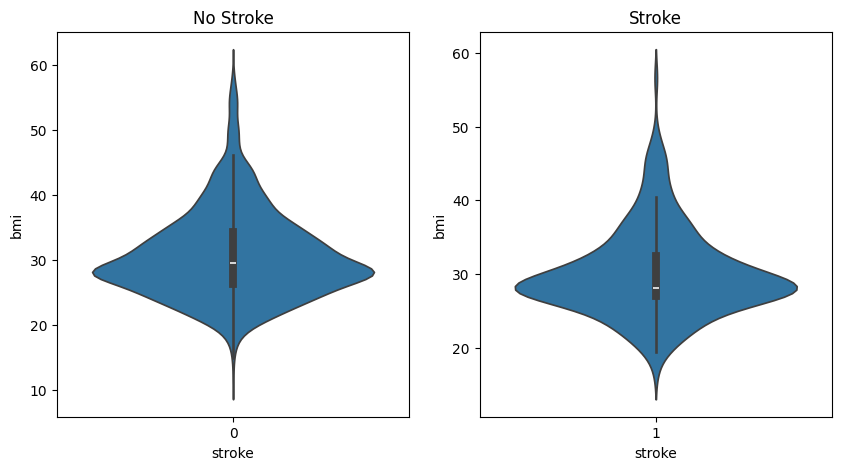

In [423]:

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

sns.violinplot(x='stroke', y='bmi', data=clean_df[clean_df.stroke != 1], ax=axs[0])
sns.violinplot(x='stroke', y='bmi', data=clean_df[clean_df.stroke == 1], ax=axs[1])

axs[0].set_title('No Stroke')
axs[1].set_title('Stroke')

plt.show()


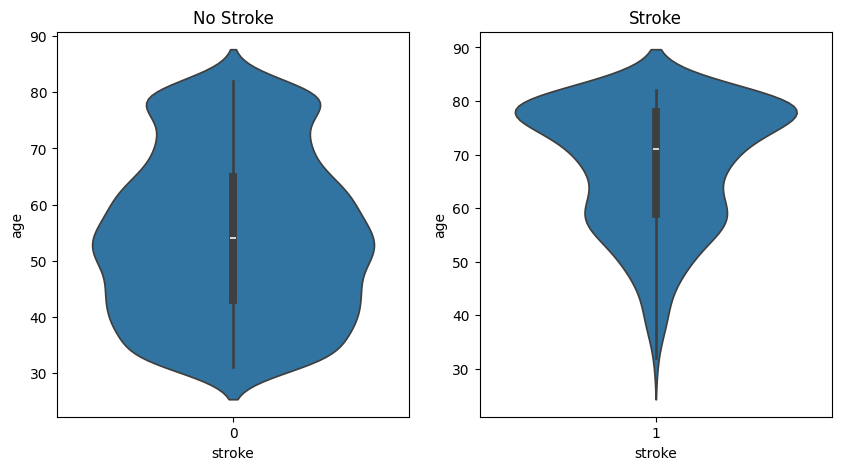

In [424]:

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

sns.violinplot(x='stroke', y='age', data=clean_df[clean_df.stroke != 1], ax=axs[0])
sns.violinplot(x='stroke', y='age', data=clean_df[clean_df.stroke == 1], ax=axs[1])

axs[0].set_title('No Stroke')
axs[1].set_title('Stroke')

plt.show()


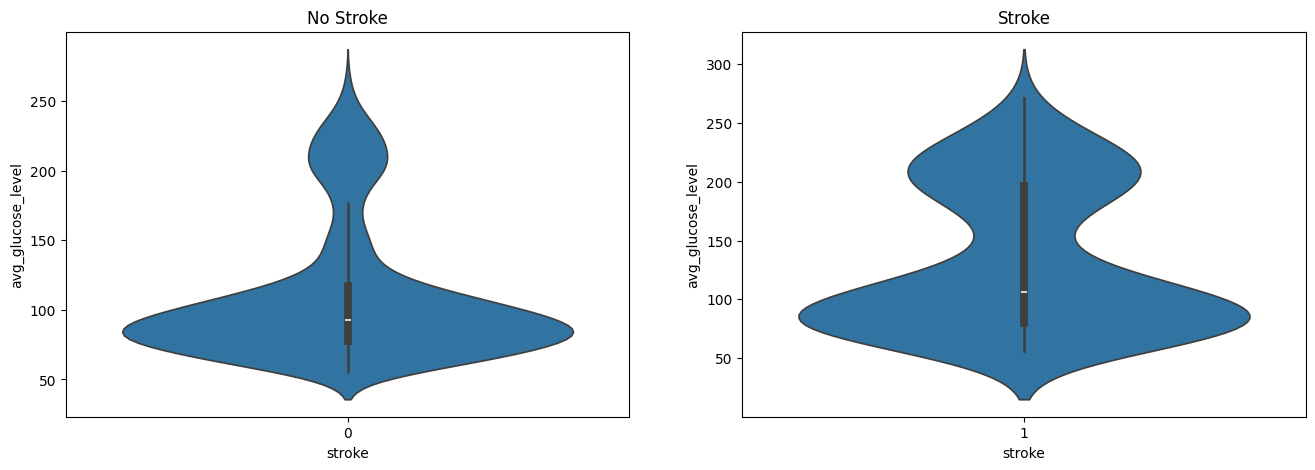

In [425]:

fig, axs = plt.subplots(1, 2, figsize=(16, 5))

sns.violinplot(x='stroke', y='avg_glucose_level', data=clean_df[clean_df.stroke != 1], ax=axs[0])
sns.violinplot(x='stroke', y='avg_glucose_level', data=clean_df[clean_df.stroke == 1], ax=axs[1])

axs[0].set_title('No Stroke')
axs[1].set_title('Stroke')

plt.show()


In [426]:
clean_df.stroke.value_counts(normalize=True)

stroke
0    0.930048
1    0.069952
Name: proportion, dtype: float64

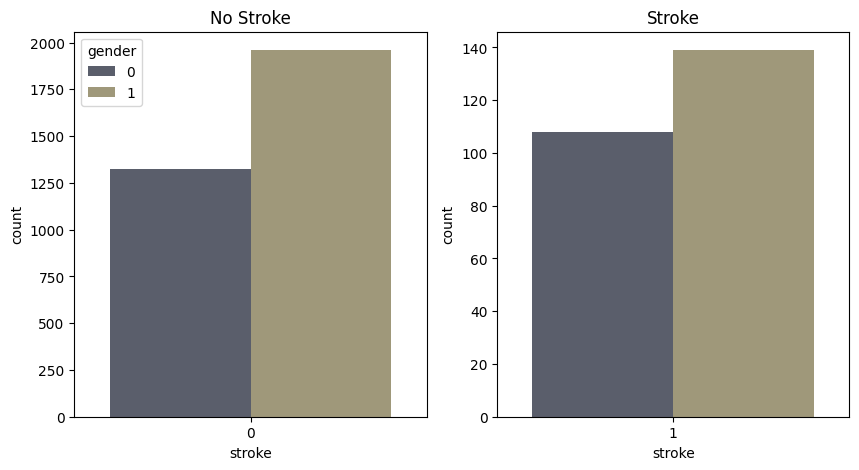

In [427]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
sns.countplot(x='stroke', hue='gender', data=clean_df[clean_df.stroke ==0], palette='cividis', ax=axs[0])
sns.countplot(x='stroke', hue='gender', data=clean_df[clean_df.stroke ==1], palette='cividis', ax=axs[1])

axs[0].set_title('No Stroke')
axs[1].set_title('Stroke')
axs[1].legend_.remove()

plt.show()


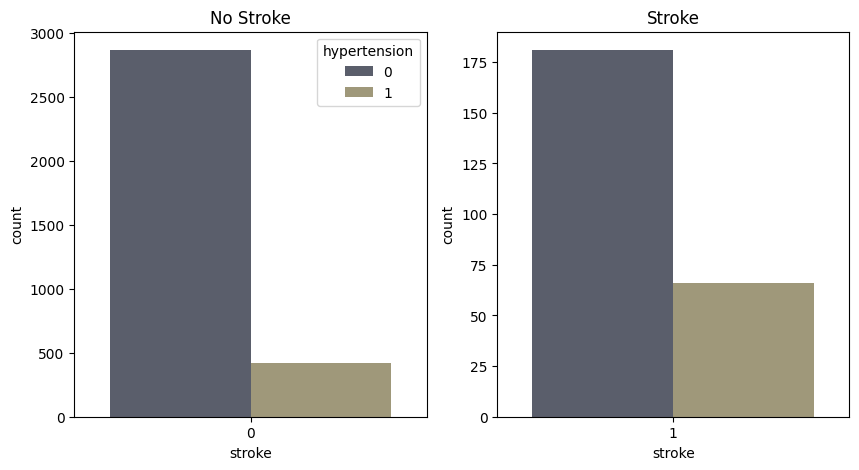

In [428]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
sns.countplot(x='stroke', hue='hypertension', data=clean_df[clean_df.stroke ==0], palette='cividis', ax=axs[0])
sns.countplot(x='stroke', hue='hypertension', data=clean_df[clean_df.stroke ==1], palette='cividis', ax=axs[1])

axs[0].set_title('No Stroke')
axs[1].set_title('Stroke')
axs[1].legend_.remove()

plt.show()


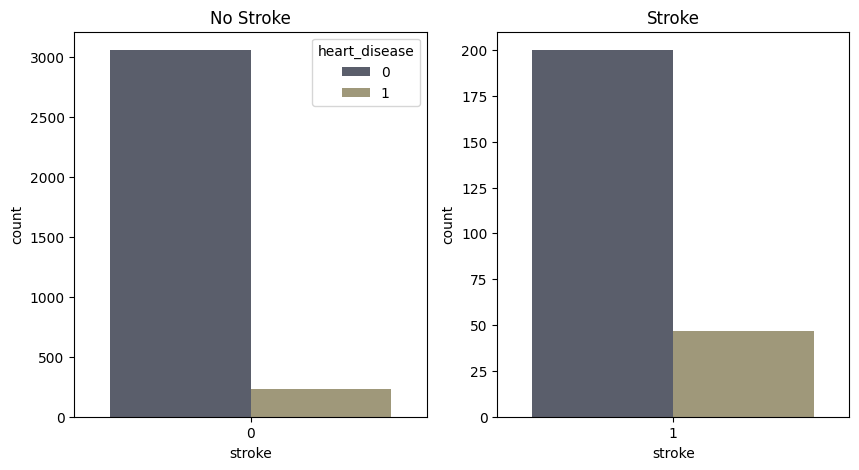

In [429]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
sns.countplot(x='stroke', hue='heart_disease', data=clean_df[clean_df.stroke ==0], palette='cividis', ax=axs[0])
sns.countplot(x='stroke', hue='heart_disease', data=clean_df[clean_df.stroke ==1], palette='cividis', ax=axs[1])

axs[0].set_title('No Stroke')
axs[1].set_title('Stroke')
axs[1].legend_.remove()

plt.show()


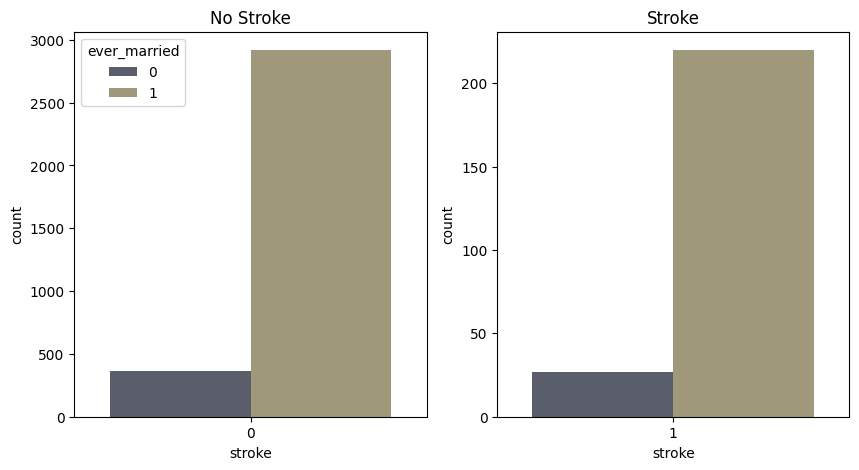

In [430]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
sns.countplot(x='stroke', hue='ever_married', data=clean_df[clean_df.stroke ==0], palette='cividis', ax=axs[0])
sns.countplot(x='stroke', hue='ever_married', data=clean_df[clean_df.stroke ==1], palette='cividis', ax=axs[1])

axs[0].set_title('No Stroke')
axs[1].set_title('Stroke')
axs[1].legend_.remove()

plt.show()


In [431]:
clean_df[clean_df.stroke !=1]['ever_married'].value_counts(normalize=True)

ever_married
1    0.888855
0    0.111145
Name: proportion, dtype: float64

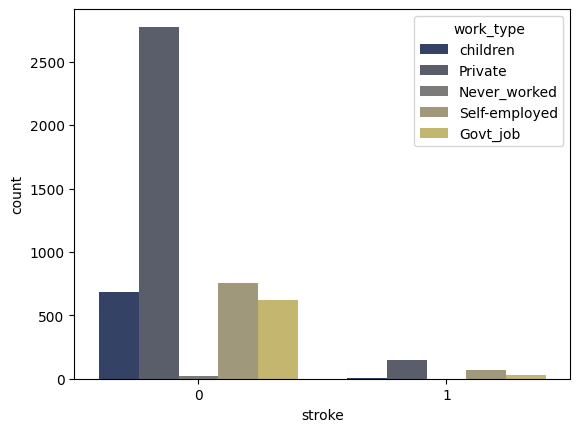

In [432]:
sns.countplot(x='stroke', hue='work_type', data=df, palette="cividis")
plt.show()

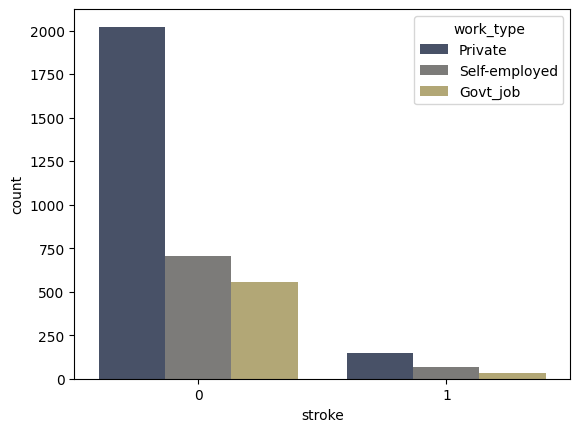

In [433]:
sns.countplot(x='stroke', hue='work_type', data=clean_df, palette='cividis')
plt.show()


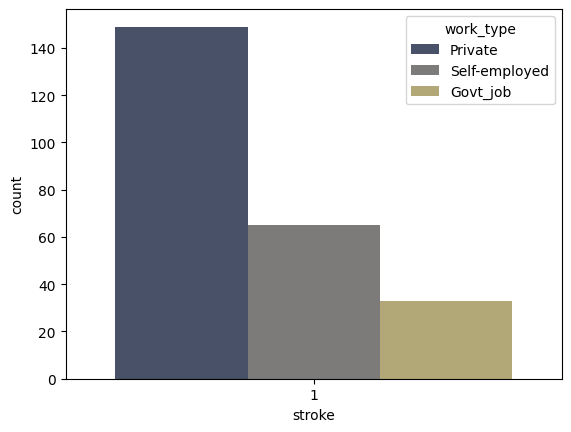

In [434]:
sns.countplot(x='stroke', hue='work_type', data=clean_df[clean_df.stroke ==1], palette="cividis")
plt.show()

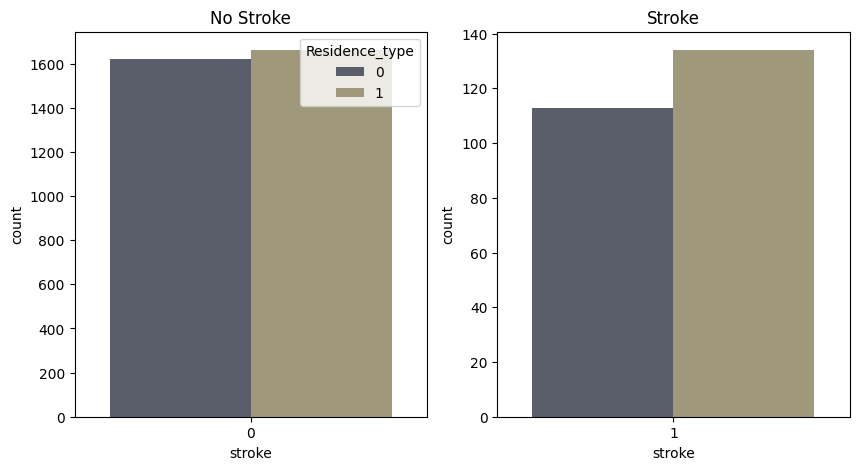

In [435]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
sns.countplot(x='stroke', hue='Residence_type', data=clean_df[clean_df.stroke ==0], palette='cividis', ax=axs[0])
sns.countplot(x='stroke', hue='Residence_type', data=clean_df[clean_df.stroke ==1], palette='cividis', ax=axs[1])

axs[0].set_title('No Stroke')
axs[1].set_title('Stroke')
axs[1].legend_.remove()

plt.show()


In [436]:

plt.show()

In [437]:
df

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


In [438]:
clean_df[clean_df.age<40]

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
49,36338,1,39.0,1,0,1,Private,0,58.09,39.2,smokes,1
118,31720,1,38.0,0,0,0,Self-employed,1,82.28,24.0,formerly smoked,1
133,31563,1,38.0,0,0,1,Private,0,101.45,28.1,formerly smoked,1
182,39912,1,32.0,0,0,1,Private,0,76.13,29.9,smokes,1
210,33943,1,39.0,0,0,1,Private,1,83.24,26.3,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5065,7789,1,31.0,0,0,1,Private,1,89.01,37.4,never smoked,0
5066,40112,1,37.0,0,0,0,Private,1,118.41,25.1,never smoked,0
5072,71957,1,35.0,0,0,1,Private,0,58.72,40.0,smokes,0
5076,39935,1,34.0,0,0,1,Private,0,174.37,23.0,never smoked,0


In [439]:
pd.DataFrame(clean_df.iloc[118,:]).transpose()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
118,31720,1,38.0,0,0,0,Self-employed,1,82.28,24.0,formerly smoked,1


In [440]:

to_classify = ['smoking_status' ]
to_robust = ['age', 'bmi']
already_processed = ['Residence_type', 'gender']

select_features = to_classify + to_robust + already_processed # + to_min_max

X = clean_df[select_features]
y = clean_df['stroke']  # Target

r2list = []
rmse_list = []
recall_list = []

# allow more accurate model's performance estimation with more training reps and
# different data splits on a small amount of data, needs to be 1 for prediction tasks.
for i in range(50):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, \
        random_state=np.random.randint(1, 20001))

    # Building Pipeline
    preprocessor = ColumnTransformer([
        ('onehot', OneHotEncoder(), to_classify),
        ('robust_scaler', MinMaxScaler(), to_robust), # RobustScaler/StandardScaler
        # ('minmax', MinMaxScaler(), to_min_max),
    ], remainder='passthrough')  # passthrough/drop

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('random_forest', SVC(random_state=0, class_weight='balanced', probability = True, max_iter= 200, gamma='auto')) #class_weight
        # ('regressor', LogisticRegression(penalty='l2', max_iter=1000, class_weight='balanced', n_jobs=8))  # Linear Regression model class_weight='balanced'
    ])
    pipeline.fit(X_train, y_train)

    r2list.append(pipeline.score(X_test, y_test))

    predicted_strokes = pipeline.predict(X_test)


    rmse_list.append(np.sqrt(mean_squared_error(y_test, predicted_strokes)))
    recall_list.append(recall_score(y_test, predicted_strokes))
    if recall_list[-1] == max(recall_list) :
        joblib.dump(pipeline, 'app/app_model/model.pkl')

print(f"# Used features count : {len(select_features) } - {select_features}") #/len(df.columns)
print(f"# Mean Recall: {np.mean(recall_list):.5f}")
print(f"# Mean r2 Test_Score: {np.mean(r2list):.5f}")
# Display RMSE
print(f"# Average prediction error: ~{np.mean(rmse_list):.4f} (RMSE)")


print(f"min/max recall result{[min(recall_list), max(recall_list)]}")

/home/julienrm/.pyenv/versions/3.8.12/envs/stroke-alert/lib/python3.8/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/julienrm/.pyenv/versions/3.8.12/envs/stroke-alert/lib/python3.8/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/julienrm/.pyenv/versions/3.8.12/envs/stroke-alert/lib/python3.8/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/julienrm/.pyenv/versions/3.8.12/envs/stroke-alert/lib/python3.8/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScale

# Used features count : 5 - ['smoking_status', 'age', 'bmi', 'Residence_type', 'gender']
# Mean Recall: 1.00000
# Mean r2 Test_Score: 0.07066
# Average prediction error: ~0.9640 (RMSE)
min/max recall result[1.0, 1.0]


/home/julienrm/.pyenv/versions/3.8.12/envs/stroke-alert/lib/python3.8/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


In [441]:
clean_df.iloc[118,:]

id                             31720
gender                             1
age                             38.0
hypertension                       0
heart_disease                      0
ever_married                       0
work_type              Self-employed
Residence_type                     1
avg_glucose_level              82.28
bmi                             24.0
smoking_status       formerly smoked
stroke                             1
Name: 118, dtype: object

In [442]:
# pd.DataFrame(clean_df.iloc[118,:][['smoking_status', 'age', 'bmi', 'Residence_type', 'gender']],\
#     columns=['smoking_status', 'age', 'bmi', 'Residence_type', 'gender'])

In [443]:
clean_df.iloc[118,:].index

Index(['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')

In [444]:
# should be 0 with that background

pipeline.predict(pd.DataFrame(clean_df.iloc[118,:]).transpose())


array([1])

4. Machine Learning


In [445]:
# df_x = df.drop(columns ="stroke")
# df_y = df['stroke']
# model = LogisticRegression()
# model.fit(df_x, df_y)
# accuracy = model.score(df_x,df_y)

In [446]:
# df = pd.read_csv("healthcare-dataset-stroke-data.csv")
# clean_df = df.copy()

# if "Other" in clean_df.gender.value_counts():
#     clean_df = df[df.gender != 'Other']
#     # on va en discuter tkt
#     clean_df = clean_df[clean_df.age>30]

#     clean_df.ever_married = clean_df.ever_married.apply(lambda x : 1 if x == "Yes" else 0)
#     clean_df.Residence_type = clean_df.Residence_type.apply(lambda x : 1 if x == "Urban" else 0)
#     clean_df.gender = clean_df.gender.apply(lambda x : 1 if x == "Female" else 0)

#     # from Sacia
#     clean_df = clean_df[clean_df.bmi <= 60]

#     # A CHANGER ABSOLUMENT
#     clean_df = clean_df.dropna(axis=0, subset='bmi')


<Axes: >

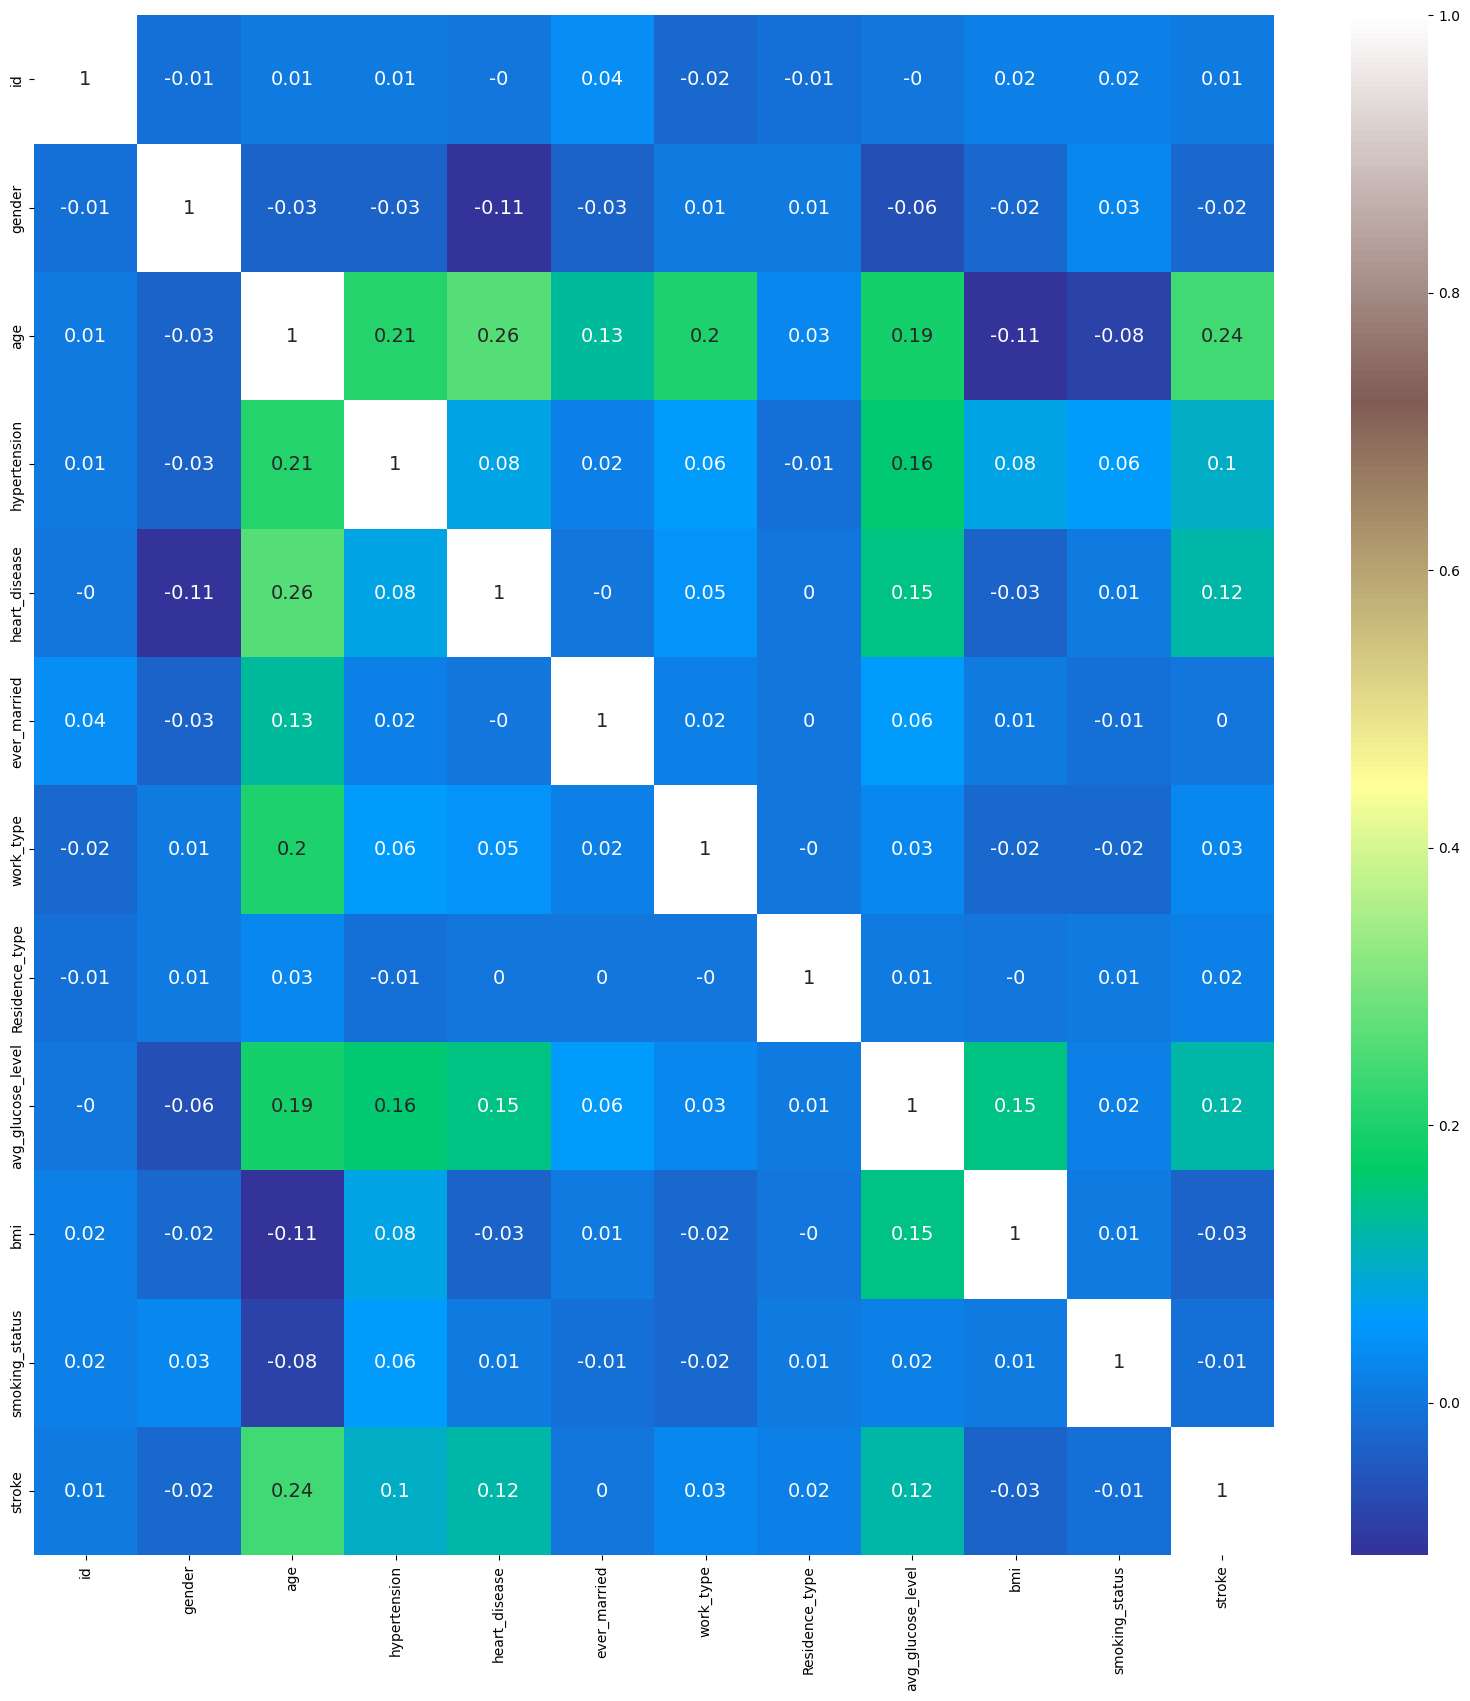

In [447]:
corr_map_df = clean_df
corr_map_df.work_type = corr_map_df['work_type'].astype('category')
corr_map_df.work_type = corr_map_df['work_type'].cat.codes

corr_map_df.smoking_status = corr_map_df['smoking_status'].astype('category')
corr_map_df.smoking_status = corr_map_df['smoking_status'].cat.codes

plt.figure(figsize = (20,20))
sns.heatmap(round(corr_map_df.corr(),2), cmap = "terrain", annot = True, annot_kws = {"size":14})
# hsv terrain jet rainbow tab10 Pastel1 Set3 RdBu viridis inferno plasma cividis magma

without class balance

In [448]:



# %%writefile my_python_file.py
# All Columns to preprocess
to_classify = ['work_type', 'smoking_status' ]
to_robust = ['age', 'avg_glucose_level', 'bmi']
# to_min_max = []
already_processed = ['gender', 'hypertension', 'heart_disease', 'ever_married', 'Residence_type']
# Bench : 'MiscFeature'
select_features = to_classify + to_robust + already_processed # + to_min_max


X = clean_df[select_features]
y = clean_df['stroke']  # Target

r2list = []
rmse_list = []
recall_list = []

# allow more accurate model's performance estimation with more training reps and
# different data splits on a small amount of data, needs to be 1 for prediction tasks.
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, \
        random_state=np.random.randint(1, 20001))

    # Building Pipeline
    preprocessor = ColumnTransformer([
        ('onehot', OneHotEncoder(), to_classify),
        ('robust_scaler', RobustScaler(), to_robust), # RobustScaler/StandardScaler
        # ('minmax', MinMaxScaler(), to_min_max),
    ], remainder='passthrough')  # passthrough/drop

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', LogisticRegression(penalty='l2', class_weight='balanced'))  # Linear Regression model
    ])
    pipeline.fit(X_train, y_train)

    # R^2 Score, not RMSE
    # train_score = pipeline.score(X_train, y_train)
    # test_score = pipeline.score(X_test, y_test)
    r2list.append(pipeline.score(X_test, y_test))
    # print(f"Training_Score: {train_score:.5f}")

    predicted_strokes = pipeline.predict(X_test)
    rmse_list.append(np.sqrt(mean_squared_error(y_test, predicted_strokes)))
    recall_list.append(recall_score(y_test, predicted_strokes))

print(f"# Used features count : {len(select_features)}") #/len(df.columns)
print(f"# Mean Recall: {np.mean(recall_list):.5f}")
print(f"# Mean r2 Test_Score: {np.mean(r2list):.5f}")
# Display RMSE
print(f"# Average prediction error: ~{np.mean(rmse_list):.4f} (RMSE)")


print(f"min/max recall result{[min(recall_list), max(recall_list)]}")

# Used features count : 10
# Mean Recall: 0.70572
# Mean r2 Test_Score: 0.69594
# Average prediction error: ~0.5513 (RMSE)
min/max recall result[0.6052631578947368, 0.7777777777777778]


with undersampling

In [449]:

class_0_df = clean_df[clean_df['stroke'] == 0]
class_1_df = clean_df[clean_df['stroke'] == 1]

undersampled_class_0_data = class_0_df.sample(n=len(class_1_df), random_state=42)
clean_df = pd.concat([undersampled_class_0_data, class_1_df])
clean_df = clean_df.sample(frac=1, random_state=42)

# Now, 'undersampled_data' contains an undersampled version of your original dataset


In [450]:



# %%writefile my_python_file.py
# All Columns to preprocess
to_classify = ['work_type', 'smoking_status' ]
to_robust = ['age', 'avg_glucose_level', 'bmi']
# to_min_max = []
already_processed = ['gender', 'hypertension', 'heart_disease', 'ever_married', 'Residence_type']
# Bench : 'MiscFeature'
select_features = to_classify + to_robust + already_processed # + to_min_max


X = clean_df[select_features]
y = clean_df['stroke']  # Target

r2list = []
rmse_list = []
recall_list = []

# allow more accurate model's performance estimation with more training reps and
# different data splits on a small amount of data, needs to be 1 for prediction tasks.
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, \
        random_state=np.random.randint(1, 20001))

    # Building Pipeline
    preprocessor = ColumnTransformer([
        ('onehot', OneHotEncoder(), to_classify),
        ('robust_scaler', RobustScaler(), to_robust), # RobustScaler/StandardScaler
        # ('minmax', MinMaxScaler(), to_min_max),
    ], remainder='passthrough')  # passthrough/drop

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', LogisticRegression(penalty='l2'))  # Linear Regression model
    ])
    pipeline.fit(X_train, y_train)

    # R^2 Score, not RMSE
    # train_score = pipeline.score(X_train, y_train)
    # test_score = pipeline.score(X_test, y_test)
    r2list.append(pipeline.score(X_test, y_test))
    # print(f"Training_Score: {train_score:.5f}")

    predicted_strokes = pipeline.predict(X_test)
    rmse_list.append(np.sqrt(mean_squared_error(y_test, predicted_strokes)))
    recall_list.append(recall_score(y_test, predicted_strokes))

print(f"# Used features count : {len(select_features)}") #/len(df.columns)
print(f"# Mean Recall: {np.mean(recall_list):.5f}")
print(f"# Mean r2 Test_Score: {np.mean(r2list):.5f}")
# Display RMSE
print(f"# Average prediction error: ~{np.mean(rmse_list):.4f} (RMSE)")


print(f"min/max recall result{[min(recall_list), max(recall_list)]}")

# Used features count : 10
# Mean Recall: 0.69615
# Mean r2 Test_Score: 0.69262
# Average prediction error: ~0.5538 (RMSE)
min/max recall result[0.6329113924050633, 0.7887323943661971]


With both undersampling and oversampling

In [451]:

class_0_df = clean_df[clean_df['stroke'] == 0]
class_1_df = clean_df[clean_df['stroke'] == 1]

undersampled_class_0_data = class_0_df.sample(n=len(class_1_df)*2, replace=True, random_state=42)
clean_df = pd.concat([class_1_df, undersampled_class_0_data, class_1_df])
clean_df = clean_df.sample(frac=1, random_state=42)

# Now, 'undersampled_data' contains an undersampled version of your original dataset


In [452]:



# %%writefile my_python_file.py
# All Columns to preprocess
to_classify = ['work_type', 'smoking_status' ]
to_robust = ['age', 'avg_glucose_level', 'bmi']
# to_min_max = []
already_processed = ['gender', 'hypertension', 'heart_disease', 'ever_married', 'Residence_type']
# Bench : 'MiscFeature'
select_features = to_classify + to_robust + already_processed # + to_min_max


X = clean_df[select_features]
y = clean_df['stroke']  # Target

r2list = []
rmse_list = []
recall_list = []

# allow more accurate model's performance estimation with more training reps and
# different data splits on a small amount of data, needs to be 1 for prediction tasks.
for i in range(50):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, \
        random_state=np.random.randint(1, 20001))

    # Building Pipeline
    preprocessor = ColumnTransformer([
        ('onehot', OneHotEncoder(), to_classify),
        ('robust_scaler', MinMaxScaler(), to_robust), # RobustScaler/StandardScaler
        # ('minmax', MinMaxScaler(), to_min_max),
    ], remainder='passthrough')  # passthrough/drop

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', LogisticRegression(penalty='l2', max_iter=1000, verbose = 0, n_jobs=4))  # Linear Regression model class_weight='balanced'
    ])
    pipeline.fit(X_train, y_train)

    # R^2 Score, not RMSE
    # train_score = pipeline.score(X_train, y_train)
    # test_score = pipeline.score(X_test, y_test)
    r2list.append(pipeline.score(X_test, y_test))
    # print(f"Training_Score: {train_score:.5f}")

    predicted_strokes = pipeline.predict(X_test)
    rmse_list.append(np.sqrt(mean_squared_error(y_test, predicted_strokes)))
    recall_list.append(recall_score(y_test, predicted_strokes))

print(f"# Used features count : {len(select_features)}") #/len(df.columns)
print(f"# Mean Recall: {np.mean(recall_list):.5f}")
print(f"# Mean r2 Test_Score: {np.mean(r2list):.5f}")
# Display RMSE
print(f"# Average prediction error: ~{np.mean(rmse_list):.4f} (RMSE)")


print(f"min/max recall result{[min(recall_list), max(recall_list)]}")

# Used features count : 10
# Mean Recall: 0.70405
# Mean r2 Test_Score: 0.68768
# Average prediction error: ~0.5584 (RMSE)
min/max recall result[0.6319444444444444, 0.7734375]


One by One Features

In [453]:
# clean_df

Categorical

In [454]:
# %%writefile my_python_file.py
# All Columns to preprocess
# to_classify = ['work_type', 'smoking_status' ]
# to_robust = ['age', 'avg_glucose_level', 'bmi']
# # to_min_max = []
# already_processed = ['gender', 'hypertension', 'heart_disease', 'ever_married', 'Residence_type']
# Bench : 'MiscFeature'
# select_features = ['work_type'] # + to_min_max
select_features = ['smoking_status']

X = clean_df[select_features]
y = clean_df['stroke']  # Target
r2list = []
rmse_list = []
recall_list = []

# allow more accurate model's performance estimation with more training reps and
# different data splits on a small amount of data, needs to be 1 for prediction tasks.
for i in range(50):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, \
        random_state=np.random.randint(1, 20001))

    # Building Pipeline
    preprocessor = ColumnTransformer([
        ('onehot', OneHotEncoder(), select_features),
        # ('robust_scaler', MinMaxScaler(), to_robust), # RobustScaler/StandardScaler
        # ('minmax', MinMaxScaler(), to_min_max),
    ], remainder='passthrough')  # passthrough/drop

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', LogisticRegression(penalty='l2', max_iter=100, class_weight='balanced'))  # Linear Regression model class_weight='balanced' , n_jobs=4
    ])
    # print(f"{X_train, y_train}")
    pipeline.fit(X_train, y_train)
    r2list.append(pipeline.score(X_test, y_test))

    predicted_strokes = pipeline.predict(X_test)
    rmse_list.append(np.sqrt(mean_squared_error(y_test, predicted_strokes)))
    recall_list.append(recall_score(y_test, predicted_strokes))

print(f"# Used features count : {len(select_features)}") #/len(df.columns)
print(f"# Mean Recall: {np.mean(recall_list):.5f}")
print(f"# Mean r2 Test_Score: {np.mean(r2list):.5f}")
# Display RMSE
print(f"# Average prediction error: ~{np.mean(rmse_list):.4f} (RMSE)")


print(f"min/max recall result{[min(recall_list), max(recall_list)]}")

# Used features count : 1
# Mean Recall: 0.63488
# Mean r2 Test_Score: 0.52828
# Average prediction error: ~0.6866 (RMSE)
min/max recall result[0.26573426573426573, 0.8636363636363636]


First attempts :

work_type : 0.42

smoking_status : 0.49


Numericals

In [455]:

# %%writefile my_python_file.py
# All Columns to preprocess
# to_classify = ['work_type', 'smoking_status' ]
# to_robust = ['age', 'avg_glucose_level', 'bmi']
# # to_min_max = []
# already_processed = ['gender', 'hypertension', 'heart_disease', 'ever_married', 'Residence_type']
# Bench : 'MiscFeature'
# select_features = ['work_type'] # + to_min_max
select_features = ['bmi']

X = clean_df[select_features]
y = clean_df['stroke']  # Target
r2list = []
rmse_list = []
recall_list = []

# allow more accurate model's performance estimation with more training reps and
# different data splits on a small amount of data, needs to be 1 for prediction tasks.
for i in range(50):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, \
        random_state=np.random.randint(1, 20001))

    # Building Pipeline
    preprocessor = ColumnTransformer([
        ('onehot', MinMaxScaler(), select_features),
        # ('robust_scaler', MinMaxScaler(), to_robust), # RobustScaler/StandardScaler
        # ('minmax', MinMaxScaler(), to_min_max),
    ], remainder='passthrough')  # passthrough/drop

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', LogisticRegression(penalty='l2', max_iter=100, class_weight='balanced'))  # Linear Regression model class_weight='balanced' , n_jobs=4
    ])
    # print(f"{X_train, y_train}")
    pipeline.fit(X_train, y_train)
    r2list.append(pipeline.score(X_test, y_test))

    predicted_strokes = pipeline.predict(X_test)
    rmse_list.append(np.sqrt(mean_squared_error(y_test, predicted_strokes)))
    recall_list.append(recall_score(y_test, predicted_strokes))

print(f"# Used features count : {len(select_features)}") #/len(df.columns)
print(f"# Mean Recall: {np.mean(recall_list):.5f}")
print(f"# Mean r2 Test_Score: {np.mean(r2list):.5f}")
# Display RMSE
print(f"# Average prediction error: ~{np.mean(rmse_list):.4f} (RMSE)")


print(f"min/max recall result{[min(recall_list), max(recall_list)]}")

# Used features count : 1
# Mean Recall: 0.60102
# Mean r2 Test_Score: 0.52088
# Average prediction error: ~0.6918 (RMSE)
min/max recall result[0.3108108108108108, 0.6944444444444444]


First attempts :

age : 0.67

avg_glucose_level : 0.42

bmi : 0.55574


Binaries

In [456]:
# %%writefile my_python_file.py
# All Columns to preprocess
# to_classify = ['work_type', 'smoking_status' ]
# to_robust = ['age', 'avg_glucose_level', 'bmi']
# # to_min_max = []
# already_processed = ['gender', 'hypertension', 'heart_disease', 'ever_married', 'Residence_type']
# Bench : 'MiscFeature'
# select_features = ['work_type'] # + to_min_max
select_features = ['Residence_type']

X = clean_df[select_features]
y = clean_df['stroke']  # Target
r2list = []
rmse_list = []
recall_list = []

# allow more accurate model's performance estimation with more training reps and
# different data splits on a small amount of data, needs to be 1 for prediction tasks.
for i in range(50):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, \
        random_state=np.random.randint(1, 20001))

    # Building Pipeline
    preprocessor = ColumnTransformer([
        ('onehot', OneHotEncoder(), select_features),
        # ('robust_scaler', MinMaxScaler(), to_robust), # RobustScaler/StandardScaler
        # ('minmax', MinMaxScaler(), to_min_max),
    ], remainder='passthrough')  # passthrough/drop

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', LogisticRegression(penalty='l2', max_iter=100, class_weight='balanced'))  # Linear Regression model class_weight='balanced' , n_jobs=4
    ])
    # print(f"{X_train, y_train}")
    pipeline.fit(X_train, y_train)
    r2list.append(pipeline.score(X_test, y_test))

    predicted_strokes = pipeline.predict(X_test)
    rmse_list.append(np.sqrt(mean_squared_error(y_test, predicted_strokes)))
    recall_list.append(recall_score(y_test, predicted_strokes))

print(f"# Used features count : {len(select_features)}") #/len(df.columns)
print(f"# Mean Recall: {np.mean(recall_list):.5f}")
print(f"# Mean r2 Test_Score: {np.mean(r2list):.5f}")
# Display RMSE
print(f"# Average prediction error: ~{np.mean(rmse_list):.4f} (RMSE)")


print(f"min/max recall result{[min(recall_list), max(recall_list)]}")

# Used features count : 1
# Mean Recall: 0.52186
# Mean r2 Test_Score: 0.50054
# Average prediction error: ~0.7065 (RMSE)
min/max recall result[0.40993788819875776, 0.5921052631578947]


First attempts :

gender : 0.42

hypertension : 0.28

heart_disease : 0.19

ever_married : 0.42845

Residence_type : 0.49


work_type : 0.42

smoking_status : 0.49





age : 0.67

avg_glucose_level : 0.42

bmi : 0.55574




gender : 0.42

hypertension : 0.28

heart_disease : 0.19

ever_married : 0.42845

Residence_type : 0.49

In [457]:
features_to_keep = ['age', 'bmi', 'smoking_status', 'Residence_type']


Regression with proper features

In [458]:
# %%writefile my_python_file.py
# All Columns to preprocess
to_classify = ['smoking_status' ]
to_robust = ['age', 'bmi']
# to_min_max = []
already_processed = ['Residence_type']
# Bench : 'MiscFeature'
select_features = to_classify + to_robust + already_processed # + to_min_max


X = clean_df[select_features]
y = clean_df['stroke']  # Target

r2list = []
rmse_list = []
recall_list = []

# allow more accurate model's performance estimation with more training reps and
# different data splits on a small amount of data, needs to be 1 for prediction tasks.
for i in range(50):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, \
        random_state=np.random.randint(1, 20001))

    # Building Pipeline
    preprocessor = ColumnTransformer([
        ('onehot', OneHotEncoder(), to_classify),
        ('robust_scaler', MinMaxScaler(), to_robust), # RobustScaler/StandardScaler
        # ('minmax', MinMaxScaler(), to_min_max),
    ], remainder='passthrough')  # passthrough/drop

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', LogisticRegression(penalty='l2', max_iter=1000, class_weight='balanced', n_jobs=8))  # Linear Regression model class_weight='balanced'
    ])
    pipeline.fit(X_train, y_train)

    # R^2 Score, not RMSE
    # train_score = pipeline.score(X_train, y_train)
    # test_score = pipeline.score(X_test, y_test)
    r2list.append(pipeline.score(X_test, y_test))
    # print(f"Training_Score: {train_score:.5f}")

    predicted_strokes = pipeline.predict(X_test)
    rmse_list.append(np.sqrt(mean_squared_error(y_test, predicted_strokes)))
    recall_list.append(recall_score(y_test, predicted_strokes))

print(f"# Used features count : {len(select_features) } - {select_features}") #/len(df.columns)
print(f"# Mean Recall: {np.mean(recall_list):.5f}")
print(f"# Mean r2 Test_Score: {np.mean(r2list):.5f}")
# Display RMSE
print(f"# Average prediction error: ~{np.mean(rmse_list):.4f} (RMSE)")


print(f"min/max recall result{[min(recall_list), max(recall_list)]}")

# Used features count : 4 - ['smoking_status', 'age', 'bmi', 'Residence_type']
# Mean Recall: 0.72622
# Mean r2 Test_Score: 0.69481
# Average prediction error: ~0.5521 (RMSE)
min/max recall result[0.6535947712418301, 0.7931034482758621]


In [459]:
# %%writefile my_python_file.py
# All Columns to preprocess
to_robust = ['age', 'bmi']
# to_min_max = []
# Bench : 'MiscFeature'
select_features = to_robust # + to_min_max


X = clean_df[select_features]
y = clean_df['stroke']  # Target

r2list = []
rmse_list = []
recall_list = []

# allow more accurate model's performance estimation with more training reps and
# different data splits on a small amount of data, needs to be 1 for prediction tasks.
for i in range(50):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, \
        random_state=np.random.randint(1, 20001))

    # Building Pipeline
    preprocessor = ColumnTransformer([
        ('robust_scaler', MinMaxScaler(), to_robust) # RobustScaler/StandardScaler
        # ('minmax', MinMaxScaler(), to_min_max),
    ], remainder='passthrough')  # passthrough/drop

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', LogisticRegression(penalty='l2', max_iter=1000, class_weight='balanced', n_jobs=8))  # Linear Regression model class_weight='balanced'
    ])
    pipeline.fit(X_train, y_train)

    # R^2 Score, not RMSE
    # train_score = pipeline.score(X_train, y_train)
    # test_score = pipeline.score(X_test, y_test)
    r2list.append(pipeline.score(X_test, y_test))
    # print(f"Training_Score: {train_score:.5f}")

    predicted_strokes = pipeline.predict(X_test)
    rmse_list.append(np.sqrt(mean_squared_error(y_test, predicted_strokes)))
    recall_list.append(recall_score(y_test, predicted_strokes))

print(f"# Used features count : {len(select_features) } - {select_features}") #/len(df.columns)
print(f"# Mean Recall: {np.mean(recall_list):.5f}")
print(f"# Mean r2 Test_Score: {np.mean(r2list):.5f}")
# Display RMSE
print(f"# Average prediction error: ~{np.mean(rmse_list):.4f} (RMSE)")


print(f"min/max recall result{[min(recall_list), max(recall_list)]}")

# Used features count : 2 - ['age', 'bmi']
# Mean Recall: 0.69085
# Mean r2 Test_Score: 0.67845
# Average prediction error: ~0.5667 (RMSE)
min/max recall result[0.6232876712328768, 0.7619047619047619]


# RandomForestClassifier

In [460]:
# from sklearn.datasets import make_classification
# X, y = make_classification(n_samples=1000, n_features=4,
#                            n_informative=2, n_redundant=0,
#                            random_state=0, shuffle=False)



# clf = RandomForestClassifier(max_depth=2, random_state=0)
# clf.fit(X, y)
# print(clf.predict([[0, 0, 0, 0]]))


In [461]:
clean_df

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
17,34120,0,75.0,1,0,1,1,1,221.29,25.8,3,1
3862,48871,1,54.0,0,0,1,1,0,68.60,44.8,3,0
2234,64494,1,34.0,0,0,1,1,1,133.82,20.4,2,0
3625,40210,0,78.0,0,1,1,2,0,206.62,28.0,1,0
175,14431,0,72.0,1,0,1,2,0,185.49,37.1,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...
60,10710,1,56.0,0,0,1,1,1,185.17,40.4,1,1
1193,70678,1,55.0,0,1,0,1,0,109.69,22.2,3,0
43,1845,1,63.0,0,0,1,1,1,90.90,28.1,1,1
4134,18178,1,48.0,0,0,1,1,1,86.06,36.2,2,0


In [462]:

to_classify = ['smoking_status' ]
to_robust = ['age', 'bmi']
already_processed = ['hypertension'] #Residence_type

select_features = to_classify + to_robust + already_processed # + to_min_max

X = clean_df[select_features]
y = clean_df['stroke']  # Target

r2list = []
rmse_list = []
recall_list = []

# allow more accurate model's performance estimation with more training reps and
# different data splits on a small amount of data, needs to be 1 for prediction tasks.
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, \
        random_state=np.random.randint(1, 20001))

    # Building Pipeline
    preprocessor = ColumnTransformer([
        ('onehot', OneHotEncoder(), to_classify),
        ('robust_scaler', MinMaxScaler(), to_robust), # RobustScaler/StandardScaler
        # ('minmax', MinMaxScaler(), to_min_max),
    ], remainder='passthrough')  # passthrough/drop

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('random_forest', RandomForestClassifier(max_depth=1, n_estimators=1000, random_state=0, class_weight='balanced'))
        # ('regressor', LogisticRegression(penalty='l2', max_iter=1000, class_weight='balanced', n_jobs=8))  # Linear Regression model class_weight='balanced'
    ])
    pipeline.fit(X_train, y_train)

    # R^2 Score, not RMSE
    # train_score = pipeline.score(X_train, y_train)
    # test_score = pipeline.score(X_test, y_test)
    r2list.append(pipeline.score(X_test, y_test))
    # print(f"Training_Score: {train_score:.5f}")

    predicted_strokes = pipeline.predict(X_test)
    rmse_list.append(np.sqrt(mean_squared_error(y_test, predicted_strokes)))
    recall_list.append(recall_score(y_test, predicted_strokes))

print(f"# Used features count : {len(select_features) } - {select_features}") #/len(df.columns)
print(f"# Mean Recall: {np.mean(recall_list):.5f}")
print(f"# Mean r2 Test_Score: {np.mean(r2list):.5f}")
# Display RMSE
print(f"# Average prediction error: ~{np.mean(rmse_list):.4f} (RMSE)")


print(f"min/max recall result{[min(recall_list), max(recall_list)]}")

# Used features count : 4 - ['smoking_status', 'age', 'bmi', 'hypertension']
# Mean Recall: 0.80863
# Mean r2 Test_Score: 0.70505
# Average prediction error: ~0.5423 (RMSE)
min/max recall result[0.7534246575342466, 0.8441558441558441]


In [463]:
df = pd.read_csv("healthcare-dataset-stroke-data.csv")
clean_df = df.copy()

if "Other" in clean_df.gender.value_counts():
    clean_df = df[df.gender != 'Other']
    # on va en discuter tkt
    clean_df = clean_df[clean_df.age>30]
    # clean_df = clean_df.dropna(axis=0, subset='bmi')

    # binaires à faire dans la pipeline dans le script bonus
    clean_df.ever_married = clean_df.ever_married.apply(lambda x : 1 if x == "Yes" else 0)
    clean_df.Residence_type = clean_df.Residence_type.apply(lambda x : 1 if x == "Urban" else 0)
    clean_df.gender = clean_df.gender.apply(lambda x : 1 if x == "Female" else 0)
    # clean_df.bmi = clean_df.bmi.apply(lambda x : x if isinstance(x, float) else 0)
    clean_df.bmi.fillna(0, inplace=True)
    clean_df = clean_df[clean_df.bmi <= 60]


In [464]:

to_classify = ['smoking_status' ]
to_robust = ['age', 'bmi']
already_processed = ['Residence_type', 'gender'] # , 'gender'

select_features = to_classify + to_robust + already_processed # + to_min_max

X = clean_df[select_features]
y = clean_df['stroke']  # Target

r2list = []
rmse_list = []
recall_list = []

# allow more accurate model's performance estimation with more training reps and
# different data splits on a small amount of data, needs to be 1 for prediction tasks.
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, \
        random_state=np.random.randint(1, 20001))

    # Building Pipeline
    preprocessor = ColumnTransformer([
        ('onehot', OneHotEncoder(), to_classify),
        ('robust_scaler', MinMaxScaler(), to_robust), # RobustScaler/StandardScaler
        # ('minmax', MinMaxScaler(), to_min_max),
    ], remainder='passthrough')  # passthrough/drop

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('random_forest', LogisticRegression(random_state=0, class_weight='balanced')) #class_weight
        # ('regressor', LogisticRegression(penalty='l2', max_iter=1000, class_weight='balanced', n_jobs=8))  # Linear Regression model class_weight='balanced'
    ])
    pipeline.fit(X_train, y_train)

    r2list.append(pipeline.score(X_test, y_test))

    predicted_strokes = pipeline.predict(X_test)


    rmse_list.append(np.sqrt(mean_squared_error(y_test, predicted_strokes)))
    recall_list.append(recall_score(y_test, predicted_strokes))
    if recall_list[-1] == max(recall_list) :
        joblib.dump(pipeline, 'app/app_model/current_model.pkl')

print(f"# Used features count : {len(select_features) } - {select_features}") #/len(df.columns)
print(f"# Mean Recall: {np.mean(recall_list):.5f}")
print(f"# Mean r2 Test_Score: {np.mean(r2list):.5f}")
# Display RMSE
print(f"# Average prediction error: ~{np.mean(rmse_list):.4f} (RMSE)")


print(f"min/max recall result{[min(recall_list), max(recall_list)]}")

# Used features count : 5 - ['smoking_status', 'age', 'bmi', 'Residence_type', 'gender']
# Mean Recall: 0.72937
# Mean r2 Test_Score: 0.69274
# Average prediction error: ~0.5542 (RMSE)
min/max recall result[0.6533333333333333, 0.7974683544303798]


In [465]:

to_classify = ['smoking_status' ]
to_robust = ['age', 'bmi']
already_processed = ['Residence_type', 'gender'] # , 'gender'

select_features = to_classify + to_robust + already_processed # + to_min_max

X = clean_df[select_features]
y = clean_df['stroke']  # Target

r2list = []
rmse_list = []
recall_list = []

# allow more accurate model's performance estimation with more training reps and
# different data splits on a small amount of data, needs to be 1 for prediction tasks.
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, \
        random_state=np.random.randint(1, 20001))

    # Building Pipeline
    preprocessor = ColumnTransformer([
        ('onehot', OneHotEncoder(), to_classify),
        ('robust_scaler', MinMaxScaler(), to_robust), # RobustScaler/StandardScaler
        # ('minmax', MinMaxScaler(), to_min_max),
    ], remainder='passthrough')  # passthrough/drop

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('random_forest', DecisionTreeClassifier(max_depth=2, random_state=0, class_weight='balanced')) #class_weight
        # ('regressor', LogisticRegression(penalty='l2', max_iter=1000, class_weight='balanced', n_jobs=8))  # Linear Regression model class_weight='balanced'
    ])
    pipeline.fit(X_train, y_train)

    r2list.append(pipeline.score(X_test, y_test))

    predicted_strokes = pipeline.predict(X_test)


    rmse_list.append(np.sqrt(mean_squared_error(y_test, predicted_strokes)))
    recall_list.append(recall_score(y_test, predicted_strokes))
    if recall_list[-1] == max(recall_list) :
        joblib.dump(pipeline, 'app/app_model/model.pkl')

print(f"# Used features count : {len(select_features) } - {select_features}") #/len(df.columns)
print(f"# Mean Recall: {np.mean(recall_list):.5f}")
print(f"# Mean r2 Test_Score: {np.mean(r2list):.5f}")
# Display RMSE
print(f"# Average prediction error: ~{np.mean(rmse_list):.4f} (RMSE)")


print(f"min/max recall result{[min(recall_list), max(recall_list)]}")

# Used features count : 5 - ['smoking_status', 'age', 'bmi', 'Residence_type', 'gender']
# Mean Recall: 0.80578
# Mean r2 Test_Score: 0.61019
# Average prediction error: ~0.6226 (RMSE)
min/max recall result[0.5757575757575758, 0.8875]


In [466]:
X.iloc[0, :]

smoking_status    formerly smoked
age                          67.0
bmi                          36.6
Residence_type                  1
gender                          0
Name: 0, dtype: object

In [467]:
model = joblib.load('app/app_model/model.pkl')
model.get_params

<bound method Pipeline.get_params of Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehot', OneHotEncoder(),
                                                  ['smoking_status']),
                                                 ('robust_scaler',
                                                  MinMaxScaler(),
                                                  ['age', 'bmi'])])),
                ('random_forest',
                 DecisionTreeClassifier(class_weight='balanced', max_depth=2,
                                        random_state=0))])>

In [468]:
df = pd.read_csv("healthcare-dataset-stroke-data.csv")
clean_df = df.copy()

if "Other" in clean_df.gender.value_counts():
    clean_df = df[df.gender != 'Other']
    # on va en discuter tkt
    clean_df = clean_df[clean_df.age>30]
    # clean_df = clean_df.dropna(axis=0, subset='bmi')

    # binaires à faire dans la pipeline dans le script bonus
    clean_df.ever_married = clean_df.ever_married.apply(lambda x : 1 if x == "Yes" else 0)
    clean_df.Residence_type = clean_df.Residence_type.apply(lambda x : 1 if x == "Urban" else 0)
    clean_df.gender = clean_df.gender.apply(lambda x : 1 if x == "Female" else 0)
    # clean_df.bmi = clean_df.bmi.apply(lambda x : x if isinstance(x, float) else 0)
    clean_df.bmi.fillna(0, inplace=True)
    clean_df = clean_df[clean_df.bmi <= 60]


In [469]:
clean_df.smoking_status

0       formerly smoked
1          never smoked
2          never smoked
3                smokes
4          never smoked
             ...       
5105       never smoked
5106       never smoked
5107       never smoked
5108    formerly smoked
5109            Unknown
Name: smoking_status, Length: 3531, dtype: object

In [470]:
df.smoking_status

0       formerly smoked
1          never smoked
2          never smoked
3                smokes
4          never smoked
             ...       
5105       never smoked
5106       never smoked
5107       never smoked
5108    formerly smoked
5109            Unknown
Name: smoking_status, Length: 5110, dtype: object

In [471]:


select_features = to_classify + to_robust + already_processed # + to_min_max

X = clean_df[select_features]
y = clean_df['stroke']  # Target

r2list = []
rmse_list = []
recall_list = []

# allow more accurate model's performance estimation with more training reps and
# different data splits on a small amount of data, needs to be 1 for prediction tasks.
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, \
        random_state=np.random.randint(1, 20001))

    # Building Pipeline
    preprocessor = ColumnTransformer([
        ('onehot', OneHotEncoder(), to_classify),
        ('robust_scaler', StandardScaler(), to_robust), # RobustScaler/StandardScaler/MinMaxScaler
        # ('minmax', MinMaxScaler(), to_min_max),
    ], remainder='passthrough')  # passthrough/drop

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('random_forest', DecisionTreeClassifier(max_depth=2, random_state=0, class_weight='balanced')) #class_weight
        # ('regressor', LogisticRegression(penalty='l2', max_iter=1000, class_weight='balanced', n_jobs=8))  # Linear Regression model class_weight='balanced'
    ])
    pipeline.fit(X_train, y_train)

    r2list.append(pipeline.score(X_test, y_test))

    predicted_strokes = pipeline.predict(X_test)
    rmse_list.append(np.sqrt(mean_squared_error(y_test, predicted_strokes)))
    recall_list.append(recall_score(y_test, predicted_strokes))

print(f"# Used features count : {len(select_features) } - {select_features}") #/len(df.columns)
print(f"# Mean Recall: {np.mean(recall_list):.5f}")
print(f"# Mean r2 Test_Score: {np.mean(r2list):.5f}")
# Display RMSE
print(f"# Average prediction error: ~{np.mean(rmse_list):.4f} (RMSE)")


print(f"min/max recall result{[min(recall_list), max(recall_list)]}")

# Used features count : 5 - ['smoking_status', 'age', 'bmi', 'Residence_type', 'gender']
# Mean Recall: 0.81068
# Mean r2 Test_Score: 0.59925
# Average prediction error: ~0.6306 (RMSE)
min/max recall result[0.6, 0.9047619047619048]


In [472]:
clean_df

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,0,67.0,0,1,1,Private,1,228.69,36.6,formerly smoked,1
1,51676,1,61.0,0,0,1,Self-employed,0,202.21,0.0,never smoked,1
2,31112,0,80.0,0,1,1,Private,0,105.92,32.5,never smoked,1
3,60182,1,49.0,0,0,1,Private,1,171.23,34.4,smokes,1
4,1665,1,79.0,1,0,1,Self-employed,0,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,1,80.0,1,0,1,Private,1,83.75,0.0,never smoked,0
5106,44873,1,81.0,0,0,1,Self-employed,1,125.20,40.0,never smoked,0
5107,19723,1,35.0,0,0,1,Self-employed,0,82.99,30.6,never smoked,0
5108,37544,0,51.0,0,0,1,Private,0,166.29,25.6,formerly smoked,0


# Learning curve


In [473]:
# # %%writefile my_python_file.py
# # All Columns to preprocess
# # to_classify = ['work_type', 'smoking_status' ]
# # to_robust = ['age', 'avg_glucose_level', 'bmi']
# # # to_min_max = []
# # already_processed = ['gender', 'hypertension', 'heart_disease', 'ever_married', 'Residence_type']
# # Bench : 'MiscFeature'
# # select_features = ['work_type'] # + to_min_max
# select_features = ['Residence_type']

# X = clean_df[select_features]
# y = clean_df['stroke']  # Target
# r2list = []
# rmse_list = []
# recall_list = []

# # allow more accurate model's performance estimation with more training reps and
# # different data splits on a small amount of data, needs to be 1 for prediction tasks.
# for i in range(50):
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, \
#         random_state=np.random.randint(1, 20001))

#     # Building Pipeline
#     preprocessor = ColumnTransformer([
#         ('onehot', OneHotEncoder(), select_features),
#         # ('robust_scaler', MinMaxScaler(), to_robust), # RobustScaler/StandardScaler
#         # ('minmax', MinMaxScaler(), to_min_max),
#     ], remainder='passthrough')  # passthrough/drop

#     pipeline = Pipeline([
#         ('preprocessor', preprocessor),
#         ('regressor', learning_curve(estimator=SVR, X=X_test, y=y_test, cv=5))  # Linear Regression model class_weight='balanced' , n_jobs=4
#     ])
#     # print(f"{X_train, y_train}")
#     pipeline.fit(X_train, y_train)
#     r2list.append(pipeline.score(X_test, y_test))

#     predicted_strokes = pipeline.predict(X_test)
#     rmse_list.append(np.sqrt(mean_squared_error(y_test, predicted_strokes)))
#     recall_list.append(recall_score(y_test, predicted_strokes))

# print(f"# Used features count : {len(select_features)}") #/len(df.columns)
# print(f"# Mean Recall: {np.mean(recall_list):.5f}")
# print(f"# Mean r2 Test_Score: {np.mean(r2list):.5f}")
# # Display RMSE
# print(f"# Average prediction error: ~{np.mean(rmse_list):.4f} (RMSE)")


# print(f"min/max recall result{[min(recall_list), max(recall_list)]}")

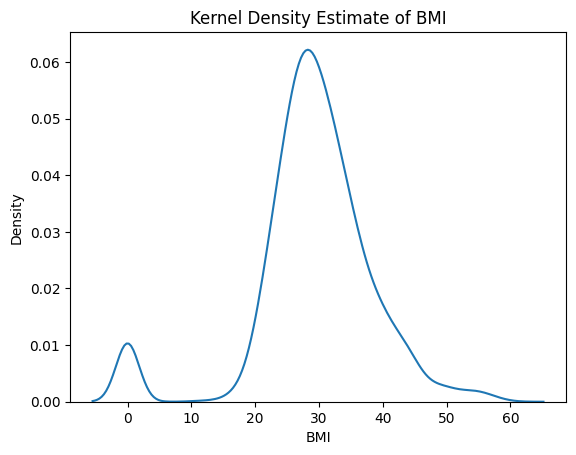

In [474]:
sns.kdeplot(clean_df['bmi'])
plt.xlabel('BMI')
plt.ylabel('Density')
plt.title('Kernel Density Estimate of BMI')
plt.show()

# Script

In [475]:
df = pd.read_csv("healthcare-dataset-stroke-data.csv")
clean_df = df.copy()

if "Other" in clean_df.gender.value_counts():
    clean_df = df[df.gender != 'Other']
    # on va en discuter tkt
    clean_df = clean_df[clean_df.age>30]
    # clean_df = clean_df.dropna(axis=0, subset='bmi')

    # binaires à faire dans la pipeline dans le script bonus
    clean_df.ever_married = clean_df.ever_married.apply(lambda x : 1 if x == "Yes" else 0)
    clean_df.Residence_type = clean_df.Residence_type.apply(lambda x : 1 if x == "Urban" else 0)
    clean_df.gender = clean_df.gender.apply(lambda x : 1 if x == "Female" else 0)
    # clean_df.bmi = clean_df.bmi.apply(lambda x : x if isinstance(x, float) else 0)

    clean_df['bmi'] = clean_df['bmi'].fillna(df['bmi'].median())
    # ideally do this before fillna but it discards nans too
    clean_df = clean_df[clean_df.bmi <= 60]

    class_0_df = clean_df[clean_df['stroke'] == 0]
    class_1_df = clean_df[clean_df['stroke'] == 1]
    undersampled_class_0_data = class_0_df.sample(n=len(class_1_df), replace=True, random_state=42) #*2
    # undersampled_class_0_data = class_0_df.sample(n=len(class_1_df)*2, replace=True, random_state=42)
    clean_df = pd.concat([class_1_df, undersampled_class_0_data]) #class_1_df
    clean_df = clean_df.sample(frac=1, random_state=42)
clean_df.stroke.value_counts()


stroke
0    247
1    247
Name: count, dtype: int64

In [476]:
select_features = ['bmi']

X = clean_df[select_features]
y = clean_df['stroke']  # Target

recall = make_scorer(recall_score)
precision_scorer = make_scorer(precision_score)
recall_list = []
precision_list = []

# allow more accurate model's performance estimation with more training reps and
# different data splits on a small amount of data, needs to be 1 for prediction tasks.
for i in range(20):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # random_state=np.random.randint(1, 20001) 42

    # Building Pipeline
    preprocessor = ColumnTransformer([
        ('minmax', MinMaxScaler(), select_features), # ('robust_scaler', RobustScaler(), to_robust), # RobustScaler/StandardScaler ('minmax', MinMaxScaler(), to_min_max),
    ], remainder='passthrough')  # passthrough/drop

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', LogisticRegression(penalty='l2', max_iter=100000, class_weight='balanced'))  # Linear Regression model class_weight='balanced' , n_jobs=4
    ])

    pipeline.fit(X_train, y_train)

    recall_list.append(cross_val_score(pipeline, X_test, y_test, cv=5, scoring=recall).mean())
    precision_list.append(cross_val_score(pipeline, X_test, y_test, cv=5, scoring=precision_scorer, verbose=0).mean()) # precision , error_score=0, n_jobs=-1

print(f"# Used features count : {len(select_features) } - {select_features}") #/len(df.columns)
print(f"# Mean Precision: {np.mean(precision_list):.5f}")
print(f"min/max Precision result{[min(precision_list), max(precision_list)]}")
print(f"# Mean Recall: {np.mean(recall_list):.5f}")
print(f"min/max recall result{[min(recall_list), max(recall_list)]}")

# Used features count : 1 - ['bmi']
# Mean Precision: 0.53116
min/max Precision result[0.42555994729907776, 0.6700060861051573]
# Mean Recall: 0.61133
min/max recall result[0.4276190476190476, 0.7066666666666667]


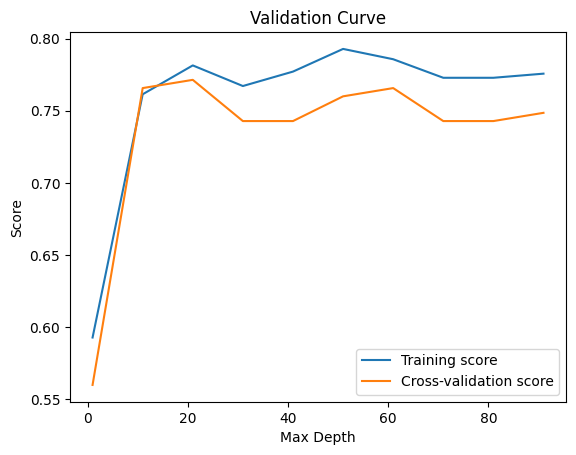

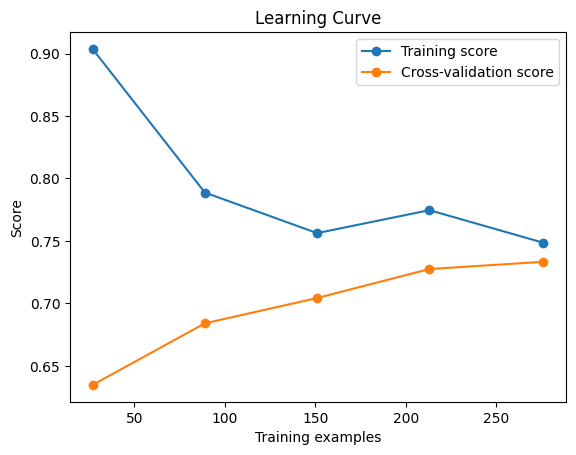

# Used features count : 4 - ['smoking_status', 'bmi', 'age', 'gender']
# Mean Precision: 0.65560
min/max Precision result[0.5574074074074075, 0.7149306833517359]
# Mean Recall: 0.66746
min/max recall result[0.5318681318681319, 0.8411764705882353]


In [477]:
to_classify = ['smoking_status' ]
to_scale = ['bmi', 'age']
already_processed = ['gender']

select_features = to_classify + to_scale + already_processed # + to_min_max
X = clean_df[select_features]
y = clean_df['stroke']  # Target

recall = make_scorer(recall_score)
precision_scorer = make_scorer(precision_score)
recall_list = []
precision_list = []

# allow more accurate model's performance estimation with more training reps and
# different data splits on a small amount of data, needs to be 1 for prediction tasks.
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, \
        random_state=np.random.randint(1, 20001))

    # Building Pipeline
    preprocessor = ColumnTransformer([
        ('onehot', OneHotEncoder(), to_classify),
        ('robust_scaler', RobustScaler(), to_scale), # RobustScaler/StandardScaler/MinMaxScaler
        # ('minmax_scaler', MinMaxScaler(), to_min_max),
        # ('minmax', MinMaxScaler(), to_min_max),
    ], remainder='passthrough')  # passthrough/drop

    pipeline = Pipeline([
        ('preprocessor', preprocessor), #class_weight='balanced' #, early_stopping=True, n_iter_no_change=5
        ('random_forest_classifier', RandomForestClassifier(max_depth=2, random_state=0)) #class_weight, class_weight='balanced', class_weight='balanced', class_weight='balanced', class_weight='balanced'

        # RandomForestClassifier DecisionTreeClassifier
        # ('regressor', LogisticRegression(penalty='l2', max_iter=1000, class_weight='balanced', n_jobs=8))  # Linear Regression model class_weight='balanced'
    ])
    pipeline.fit(X_train, y_train)


    recall_list.append(cross_val_score(pipeline, X_test, y_test, cv=5, scoring=recall).mean())
    precision_list.append(cross_val_score(pipeline, X_test, y_test, cv=5, scoring=precision_scorer, verbose=0).mean()) # precision , error_score=0, n_jobs=-1
    # precision = precision_score(y_true, y_pred, zero_division=1)

param_range = np.arange(1, 100, 10)  # Example range of parameter values
train_scores, test_scores = validation_curve(
    pipeline, X_train, y_train, param_name="random_forest_classifier__n_estimators", param_range=param_range,
    scoring="recall", n_jobs=1)

plt.figure()
plt.plot(param_range, np.mean(train_scores, axis=1), label='Training score')
plt.plot(param_range, np.mean(test_scores, axis=1), label='Cross-validation score')
plt.title('Validation Curve')
plt.xlabel('Max Depth')
plt.ylabel('Score')
plt.legend(loc="best")
plt.show()


train_sizes, train_scores_lc, test_scores_lc = learning_curve(
    pipeline, X_train, y_train, cv=5, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5))

plt.figure()
plt.plot(train_sizes, np.mean(train_scores_lc, axis=1), 'o-', label='Training score')
plt.plot(train_sizes, np.mean(test_scores_lc, axis=1), 'o-', label='Cross-validation score')
plt.title('Learning Curve')
plt.xlabel('Training examples')
plt.ylabel('Score')
plt.legend(loc="best")
plt.show()

print(f"# Used features count : {len(select_features) } - {select_features}") #/len(df.columns)
print(f"# Mean Precision: {np.mean(precision_list):.5f}")
print(f"min/max Precision result{[min(precision_list), max(precision_list)]}")
print(f"# Mean Recall: {np.mean(recall_list):.5f}")
print(f"min/max recall result{[min(recall_list), max(recall_list)]}")


# recall_list.append(recall_score(y_test, predicted_strokes))
# r2list.append(pipeline.score(X_test, y_test))
# print(f"# Mean r2 Test_Score: {np.mean(r2list):.5f}")
    # predicted_strokes = pipeline.predict(X_test)
    # rmse_list.append(np.sqrt(mean_squared_error(y_test, predicted_strokes)))
# Display RMSE
# print(f"# Average prediction error: ~{np.mean(rmse_list):.4f} (RMSE)")


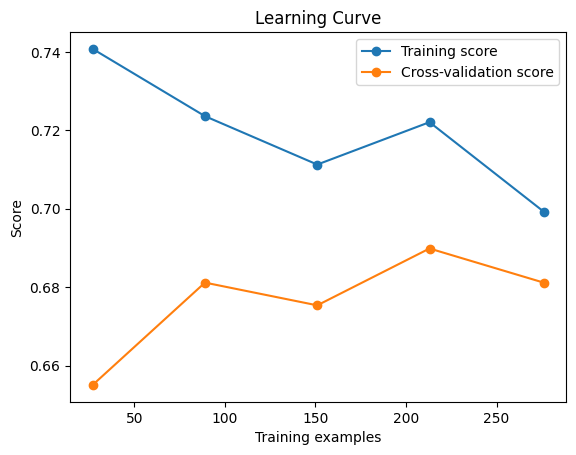

# Used features count : 4 - ['smoking_status', 'bmi', 'age', 'gender']
# Mean Precision: 0.69224
min/max Precision result[0.6299521531100478, 0.7731516290726816]
# Mean Recall: 0.73067
min/max recall result[0.6307692307692309, 0.8588235294117647]


In [478]:
to_classify = ['smoking_status' ]
to_scale = ['bmi', 'age']
already_processed = ['gender']

select_features = to_classify + to_scale + already_processed # + to_min_max
X = clean_df[select_features]
y = clean_df['stroke']  # Target

recall = make_scorer(recall_score)
precision_scorer = make_scorer(precision_score)

r2list = []
rmse_list = []
recall_list = []
cross_val_list = []
precision_list = []

# allow more accurate model's performance estimation with more training reps and
# different data splits on a small amount of data, needs to be 1 for prediction tasks.
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, \
        random_state=np.random.randint(1, 20001))

    # Building Pipeline
    preprocessor = ColumnTransformer([
        ('onehot', OneHotEncoder(), to_classify),
        ('robust_scaler', StandardScaler(), to_scale), # RobustScaler/StandardScaler/MinMaxScaler
        # ('minmax', MinMaxScaler(), to_min_max),
    ], remainder='passthrough')  # passthrough/drop

    pipeline = Pipeline([
        ('preprocessor', preprocessor), #class_weight='balanced' #, early_stopping=True, n_iter_no_change=5 class_weight='balanced'
        ('regressor', LogisticRegression(penalty='l2', max_iter=1000, n_jobs=8))
        # RandomForestClassifier DecisionTreeClassifier
        # ('regressor', LogisticRegression(penalty='l2', max_iter=1000, class_weight='balanced', n_jobs=8))  # Linear Regression model class_weight='balanced'
    ])
    pipeline.fit(X_train, y_train)

    recall_list.append(cross_val_score(pipeline, X_test, y_test, cv=5, scoring=recall).mean())
    precision_list.append(cross_val_score(pipeline, X_test, y_test, cv=5, scoring=precision_scorer, verbose=0).mean()) # precision , error_score=0, n_jobs=-1
    # precision = precision_score(y_true, y_pred, zero_division=1)

train_sizes, train_scores_lc, test_scores_lc = learning_curve(
    pipeline, X_train, y_train, cv=5, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5))

plt.figure()
plt.plot(train_sizes, np.mean(train_scores_lc, axis=1), 'o-', label='Training score')
plt.plot(train_sizes, np.mean(test_scores_lc, axis=1), 'o-', label='Cross-validation score')
plt.title('Learning Curve')
plt.xlabel('Training examples')
plt.ylabel('Score')
plt.legend(loc="best")
plt.show()

print(f"# Used features count : {len(select_features) } - {select_features}") #/len(df.columns)
print(f"# Mean Precision: {np.mean(precision_list):.5f}")
print(f"min/max Precision result{[min(precision_list), max(precision_list)]}")
print(f"# Mean Recall: {np.mean(recall_list):.5f}")
print(f"min/max recall result{[min(recall_list), max(recall_list)]}")


# recall_list.append(recall_score(y_test, predicted_strokes))
# r2list.append(pipeline.score(X_test, y_test))
# print(f"# Mean r2 Test_Score: {np.mean(r2list):.5f}")
    # predicted_strokes = pipeline.predict(X_test)
    # rmse_list.append(np.sqrt(mean_squared_error(y_test, predicted_strokes)))
# Display RMSE
# print(f"# Average prediction error: ~{np.mean(rmse_list):.4f} (RMSE)")


In [479]:
clean_df.stroke.value_counts()

stroke
0    247
1    247
Name: count, dtype: int64

In [480]:
clean_df

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
2115,8345,1,49.0,0,0,1,Private,0,114.76,24.7,never smoked,0
73,50784,0,63.0,0,0,1,Private,0,228.56,27.4,never smoked,1
3389,36728,0,74.0,0,0,1,Private,1,79.44,32.8,never smoked,0
176,62466,1,80.0,0,0,1,Private,1,64.44,45.0,never smoked,1
3171,53265,1,33.0,0,0,1,Self-employed,1,70.59,20.2,Unknown,0
...,...,...,...,...,...,...,...,...,...,...,...,...
106,42072,1,50.0,1,0,1,Private,0,73.18,30.3,formerly smoked,1
1670,34720,0,45.0,0,1,1,Private,0,93.77,28.1,Unknown,0
821,25458,1,70.0,1,0,1,Govt_job,0,88.66,36.7,formerly smoked,0
3171,53265,1,33.0,0,0,1,Self-employed,1,70.59,20.2,Unknown,0


In [481]:

to_classify = ['smoking_status']
to_scale = ['age', 'bmi', 'avg_glucose_level']
already_processed = ['Residence_type', 'gender', 'heart_disease', 'hypertension']

select_features = to_classify + to_scale + already_processed # + to_min_max

X = clean_df[select_features]
y = clean_df['stroke']  # Target

recall = make_scorer(recall_score)
precision_scorer = make_scorer(precision_score)

recall_list = []
cross_val_list = []
precision_list = []


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, \
    random_state=122) #np.random.randint(1, 20001)

# Building Pipeline
preprocessor = ColumnTransformer([
    ('onehot', OneHotEncoder(), to_classify),
    ('standard_scaler', StandardScaler(), to_scale), # RobustScaler/StandardScaler/MinMaxScaler
], remainder='passthrough')  # passthrough/drop

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('svc_model', SVC(class_weight='balanced', probability = True, max_iter= 20000, gamma='auto')) #class_weight
    # ('regressor', LogisticRegression(penalty='l2', max_iter=1000, class_weight='balanced', n_jobs=8))  # Linear Regression model class_weight='balanced'
])
pipeline.fit(X_train, y_train)

recall_list.append(cross_val_score(pipeline, X_test, y_test, cv=5, scoring=recall).mean())
precision_list.append(cross_val_score(pipeline, X_test, y_test, cv=5, scoring=precision_scorer, verbose=0).mean())


# if recall_list[-1] == max(recall_list) :
#     joblib.dump(pipeline, 'app/app_model/model.pkl')

print(f"# Used features count : {len(select_features) } - {select_features}") #/len(df.columns)
print(f"# Mean Precision: {np.mean(precision_list):.5f}")
print(f"min/max Precision result{[min(precision_list), max(precision_list)]}")
print(f"# Mean Recall: {np.mean(recall_list):.5f}")
print(f"min/max recall result{[min(recall_list), max(recall_list)]}")


# Used features count : 8 - ['smoking_status', 'age', 'bmi', 'avg_glucose_level', 'Residence_type', 'gender', 'heart_disease', 'hypertension']
# Mean Precision: 0.70742
min/max Precision result[0.7074157868275516, 0.7074157868275516]
# Mean Recall: 0.79333
min/max recall result[0.7933333333333333, 0.7933333333333333]


In [482]:
clean_df = df[df.gender != 'Other']
clean_df = clean_df[clean_df.age>30]
# binaires à faire dans la pipeline dans le script bonus
clean_df.ever_married = clean_df.ever_married.apply(lambda x : 1 if x == "Yes" else 0)
clean_df.Residence_type = clean_df.Residence_type.apply(lambda x : 1 if x == "Urban" else 0)
clean_df.gender = clean_df.gender.apply(lambda x : 1 if x == "Female" else 0)
# from Sacia
clean_df['bmi'] = clean_df['bmi'].fillna(df['bmi'].median())
clean_df = clean_df[clean_df.bmi <= 60]


clean_df.shape

(3531, 12)

In [483]:

to_classify = ['smoking_status']
to_scale = ['age', 'bmi', 'avg_glucose_level']
already_processed = ['Residence_type', 'gender', 'heart_disease']

select_features = to_scale + already_processed + to_classify# + to_classify

X = clean_df[select_features]
y = clean_df['stroke']  # Target

recall = make_scorer(recall_score)
precision_scorer = make_scorer(precision_score)

recall_list = []
cross_val_list = []
precision_list = []


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, \
    random_state=122) #np.random.randint(1, 20001)

# Building Pipeline
preprocessor = ColumnTransformer([
    # ('onehot', OneHotEncoder(), to_classify),
    ('standard_scaler', StandardScaler(), to_scale), # RobustScaler/StandardScaler/MinMaxScaler
], remainder='passthrough')  # passthrough/drop

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('svc_model', SVC(class_weight='balanced', probability = True, max_iter= 20000, gamma='auto')) #class_weight
    # ('regressor', LogisticRegression(penalty='l2', max_iter=1000, class_weight='balanced', n_jobs=8))  # Linear Regression model class_weight='balanced'
])
pipeline.fit(X_train, y_train)
#

recall_list.append(cross_val_score(pipeline, X_test, y_test, cv=5, scoring=recall).mean())
precision_list.append(cross_val_score(pipeline, X_test, y_test, cv=5, scoring=precision_scorer, verbose=0).mean())


if recall_list[-1] == max(recall_list) :
    joblib.dump(pipeline, 'app/app_model/model.pkl')

print(f"# Used features count : {len(select_features) } - {select_features}") #/len(df.columns)
print(f"# Mean Precision: {np.mean(precision_list):.5f}")
print(f"# Mean Recall: {np.mean(recall_list):.5f}")


ValueError: could not convert string to float: 'never smoked'

In [ ]:
X_train



X_train.to_csv("app/app_model/X_train.csv", index=False)


pd.read_csv("app/app_model/X_train.csv")

,age,bmi,avg_glucose_level,Residence_type,gender,heart_disease,hypertension
0,37.0,27.2,131.05,0,0,0,0
1,73.0,28.1,79.69,0,1,0,0
2,78.0,33.7,234.06,1,1,0,0
3,76.0,28.1,57.92,1,1,0,0
4,51.0,44.7,143.15,1,1,0,0
...,...,...,...,...,...,...,...
2466,31.0,35.8,62.68,1,1,0,0
2467,38.0,29.0,61.88,0,1,0,0
2468,78.0,31.4,208.99,0,1,0,0
2469,36.0,30.7,89.33,1,0,0,0


In [ ]:
# !pip install lime

In [ ]:
pipeline = joblib.load('app/app_model/model.pkl')

In [ ]:
pipeline.get_feature_names_out age bmi avg_glucose_level

<bound method Pipeline.get_feature_names_out of Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('standard_scaler',
                                                  StandardScaler(),
                                                  ['age', 'bmi',
                                                   'avg_glucose_level'])])),
                ('svc_model',
                 SVC(class_weight='balanced', gamma='auto', max_iter=20000,
                     probability=True))])>

In [ ]:
import joblib
import lime
import lime.lime_tabular
from sklearn.pipeline import Pipeline
import numpy as np

# Load your saved pipeline model
pipeline = joblib.load('app/app_model/model.pkl')
feature_names = ['age',	'bmi', 'avg_glucose_level',	'Residence_type', 'gender',	'heart_disease', 'hypertension']


# Prepare an instance of LimeTabularExplainer
explainer = lime.lime_tabular.LimeTabularExplainer(X_train,
                                                   feature_names=pipeline.feature_names_in_,
                                                   class_names=['No Stroke', 'Stroke'],
                                                   mode='classification')

# Choose an instance you want to explain (e.g., the first instance in X_train)
instance_idx = 0
instance = X_train[instance_idx]

# Explain the instance
explanation = explainer.explain_instance(instance,
                                         pipeline.predict_proba,
                                         num_features=len(feature_names))

# Visualize the explanation
explanation.show_in_notebook()


InvalidIndexError: (slice(None, None, None), 0)

In [ ]:
import joblib
import lime
import lime.lime_tabular
from sklearn.pipeline import Pipeline

# Load your saved pipeline model
pipeline = joblib.load('app/app_model/model.pkl')

# Define your feature names
feature_names = ['age', 'bmi', 'avg_glucose_level', 'Residence_type', 'gender', 'heart_disease', 'hypertension', 'smoking_status']

# Prepare an instance of LimeTabularExplainer
explainer = lime.lime_tabular.LimeTabularExplainer(feature_names=feature_names,
                                                   class_names=['No Stroke', 'Stroke'],
                                                   mode='classification')

# Choose an instance you want to explain (e.g., a sample from your dataset)
# You can create a synthetic instance for demonstration purposes
instance = [50, 30, 80, 'Urban', 'Male', 0, 1, 'never smoked']  # Example instance

# Explain the instance
explanation = explainer.explain_instance(instance,
                                         pipeline.predict_proba,
                                         num_features=len(feature_names))

# Visualize the explanation
explanation.show_in_notebook()


TypeError: __init__() missing 1 required positional argument: 'training_data'

In [ ]:
import joblib
import lime
import lime.lime_tabular
from sklearn.pipeline import Pipeline
import numpy as np

# Load your saved pipeline model
pipeline = joblib.load('app/app_model/model.pkl')

# Define your feature names
feature_names = ['age', 'bmi', 'avg_glucose_level', 'Residence_type', 'gender', 'heart_disease', 'hypertension', 'smoking_status']

# Prepare an instance of LimeTabularExplainer
explainer = lime.lime_tabular.LimeTabularExplainer(training_data=np.zeros((1, len(feature_names))),  # Dummy data
                                                   feature_names=feature_names,
                                                   class_names=['No Stroke', 'Stroke'],
                                                   mode='classification')

# Choose an instance you want to explain (e.g., a sample from your dataset)
# You can create a synthetic instance for demonstration purposes
instance = [50, 30, 80, 'Urban', 'Male', 0, 1, 'never smoked']  # Example instance

# Explain the instance
explanation = explainer.explain_instance(instance,
                                         pipeline.predict_proba,
                                         num_features=len(feature_names))

# Visualize the explanation
explanation.show_in_notebook()


AttributeError: 'list' object has no attribute 'shape'

In [ ]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values,
                                 mode='classification',
                                 class_names=['Pas AVC', 'AVC'],
                                 feature_names=list(X_train.columns),
                                 random_state=42)


In [ ]:
# X_test

In [ ]:
best_log_reg_model_explanation = explainer.explain_instance(X_test.values[3],
                                               pipeline.predict_proba,
                                               num_features = 1
                                               )
best_log_reg_model_explanation.show_in_notebook(show_table=True)

ValueError: Specifying the columns using strings is only supported for pandas DataFrames

In [ ]:
dir(pipeline)

['__abstractmethods__',
 '__annotations__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__sklearn_clone__',
 '__sklearn_is_fitted__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_build_request_for_signature',
 '_can_fit_transform',
 '_can_inverse_transform',
 '_can_transform',
 '_check_feature_names',
 '_check_fit_params',
 '_check_n_features',
 '_estimator_type',
 '_final_estimator',
 '_fit',
 '_get_default_requests',
 '_get_metadata_request',
 '_get_param_names',
 '_get_params',
 '_get_tags',
 '_iter',
 '_log_message',
 '_more_tags',
 '_parameter_constraints',
 '_replace_estimator',
 '_repr_html_',
 '_repr_html_inner',
 '_repr_m

In [ ]:
# Extract the preprocessor step from the pipeline
preprocessor = pipeline.named_steps['preprocessor']

# Transform the training data using the preprocessor
X_train = preprocessor.transform(X_train)


In [ ]:
X_train

array([[-1.25319412, -0.52455004,  0.39110091, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.23279335, -0.39049347, -0.62977357, ...,  1.        ,
         0.        ,  0.        ],
       [ 1.57806938,  0.44363627,  2.43861416, ...,  1.        ,
         0.        ,  0.        ],
       ...,
       [ 1.57806938,  0.10104727,  1.94030179, ...,  1.        ,
         0.        ,  0.        ],
       [-1.32224932, -0.00321895, -0.43816084, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.12791003,  0.23510384,  2.38395285, ...,  1.        ,
         0.        ,  0.        ]])

# Projet de Data Engineering et Data Science de la plateforme  **stroke-alert**.

## Dévelopement d'un outil d'aide à la prévention d'AVC.

L'outil aura pour mission d'effectuer une prédiction des risques pour un ou plusieurs individus de subir un accident vasculaire cérébral à partir de critères médicaux simplifiés


### Sont mis à notre disposition :

#### ● Des statistiques sur les accidents vasculaires cérébraux en France

Chiffres clés concernant les accidents vasculaires cérébraux en France :
En 2021, 121 940 personnes ont présenté un AVC aigu (52,6 % étaient des
hommes et 47,4 % des femmes).
Parmi les patients pris en charge pour un AVC aigu, certains présentaient une
ou plusieurs autres maladies cardiaques ou facteurs du risque
cardiovasculaire :
- 34 % ont des troubles du rythme cardiaque ;
- 23 % ont une forme de diabète ;
- 17 % une maladie coronaire chronique ;
- 8% une artériopathie des membres inférieurs ;
- 8% une maladie des valves cardiaques.

En 2021, 849 300 personnes ont été suivies pour des séquelles d'AVC (51,8 %
étaient des hommes et 48,2 % des femmes).
L'AVC est la première cause de mortalité chez la femme avant le cancer du
sein et la troisième chez l'homme.

Il est la première cause de handicap acquis de l’adulte et la deuxième cause
de démence après la maladie d'Alzheimer.

#### ● Une base de données contenant les variables suivantes :

- id : identifiant unique.
- gender : genre du patient.
- age : âge du patient.
- hypertension : 0 si le patient n'a pas d'hypertension, 1 si le patient a de
l'hypertension.
- heart_disease : 0 si le patient n'a pas de maladie cardiaque, 1 si le
patient a une maladie cardiaque.
- ever_married : si le patient a déjà été marié ou pas.
- work_type : type de travail du patient.
- Residence_type : type de résidence du patient "Rural" ou "Urbain".
- avg_glucose_level : taux moyen de glucose dans le sang.
- bmi : indice de masse corporelle.
- smoking_status : "a déjà fumé", "n'a jamais fumé", "fumé" ou "Inconnu ".
- stroke : 1 si le patient a eu un accident vasculaire cérébral ou 0 s'il n'en
a pas eu.

### Résumé de l'Analyse Exploratoire :

- **Il est important de noter que parmis les 5110 individus qui composent le jeu de données, seul 249 d'entre eux ont déjà subi un AVC, soit moins de 5% de la population que présente le jeu de données initial.**

- Seulement 3 personnes sur les 2024 individus de moins de 38 ans ont subis un avc dans notre jeu de données, il pourrait être intéressant d'exclure ces 2024 individus du jeu de données pour faciliter le rééquilibrage des classes toute en excluant une partie de la population très peu concernée par les risques d'AVC. Les models associeraient rapidement la relation croissante entre l'âge et les risques d'AVC qui est déjà prouvé scientifiquement et reconnu depuis des siècles : 

A partir de 55 ans, chaque décénie double le risque d'AVC.

D'après :
Rothwell PM, Coull AJ, Silver LE, et al. Population-based study of event-rate, incidence, case fatality, and mortality for all acute vascular events in all arterial territories (Oxford vascular study). Lancet 2005; 366 : 1773–83.
- Très peu de valeurs manquantes à l'exception de la variable smoking_status (30%) et dans une moindre mesure bmi (3.93%).
- On ne peut pas se séparer des valeurs manquantes de la feature bmi puisque l'on perdrait 40 de nos 249 patients ayant déjà subi un avc.


In [ ]:
df.shape

(5110, 12)

In [ ]:
df[df.stroke ==1].shape

(249, 12)

In [ ]:
df.stroke[df.bmi.isna() == True].value_counts(normalize = True)

stroke
0    0.800995
1    0.199005
Name: proportion, dtype: float64

In [ ]:
df.stroke[df.bmi.isna() == True].value_counts()

stroke
0    161
1     40
Name: count, dtype: int64

In [ ]:
df.bmi.isna().value_counts()/(4909+201)*100

bmi
False    96.066536
True      3.933464
Name: count, dtype: float64

Random W/ KNN Imputer

**** Mice gpt test

# Projet de Data Engineering et Data Science de la plateforme  **stroke-alert**.

## Informations importantes à l'appréciation du projet :
- pour le script .py de l'exécution de la prédiction



## Dévelopement d'un outil d'aide à la prévention d'AVC.

L'outil aura pour mission d'effectuer une prédiction des risques pour un ou plusieurs individus de subir un accident vasculaire cérébral à partir de critères médicaux simplifiés


### Sont mis à notre disposition :

#### ● Des statistiques sur les accidents vasculaires cérébraux en France

Chiffres clés concernant les accidents vasculaires cérébraux en France :
En 2021, 121 940 personnes ont présenté un AVC aigu (52,6 % étaient des
hommes et 47,4 % des femmes).
Parmi les patients pris en charge pour un AVC aigu, certains présentaient une
ou plusieurs autres maladies cardiaques ou facteurs du risque
cardiovasculaire :
- 34 % ont des troubles du rythme cardiaque ;
- 23 % ont une forme de diabète ;
- 17 % une maladie coronaire chronique ;
- 8% une artériopathie des membres inférieurs ;
- 8% une maladie des valves cardiaques.

En 2021, 849 300 personnes ont été suivies pour des séquelles d'AVC (51,8 %
étaient des hommes et 48,2 % des femmes).
L'AVC est la première cause de mortalité chez la femme avant le cancer du
sein et la troisième chez l'homme.

Il est la première cause de handicap acquis de l’adulte et la deuxième cause
de démence après la maladie d'Alzheimer.

#### ● Une base de données contenant les variables suivantes :

**Explication des données**
- id : identifiant unique.
- gender : genre du patient.
- age : âge du patient.
- hypertension : 0 si le patient n'a pas d'hypertension, 1 si le patient a de
l'hypertension.
- heart_disease : 0 si le patient n'a pas de maladie cardiaque, 1 si le
patient a une maladie cardiaque.
- ever_married : si le patient a déjà été marié ou pas.
- work_type : type de travail du patient.
- Residence_type : type de résidence du patient "Rural" ou "Urbain".
- avg_glucose_level : taux moyen de glucose dans le sang.
- bmi : indice de masse corporelle.
- smoking_status : "a déjà fumé", "n'a jamais fumé", "fumé" ou "Inconnu ".
- stroke : 1 si le patient a eu un accident vasculaire cérébral ou 0 s'il n'en
a pas eu.

### Résumé de l'Analyse Exploratoire :

**Premières observations :**

- **Il est important de noter que parmis les 5110 individus qui composent le jeu de données, seul 249 d'entre eux ont déjà subi un AVC, soit moins de 5% de la population que présente le jeu de données initial.**

- Seulement 3 personnes sur les 2024 individus de moins de 38 ans ont subis un avc dans notre jeu de données, il pourrait être intéressant d'exclure ces 2024 individus du jeu de données pour faciliter le rééquilibrage des classes toute en excluant une partie de la population très peu concernée par les risques d'AVC. Les models associeraient rapidement la relation croissante entre l'âge et les risques d'AVC qui est déjà prouvé scientifiquement et reconnu depuis des siècles :

A partir de 55 ans, chaque décénie double le risque d'AVC.

D'après :
Rothwell PM, Coull AJ, Silver LE, et al. Population-based study of event-rate, incidence, case fatality, and mortality for all acute vascular events in all arterial territories (Oxford vascular study). Lancet 2005; 366 : 1773–83.
- Très peu de valeurs manquantes à l'exception de la variable smoking_status (30%) et dans une moindre mesure bmi (3.93%).
- On ne peut pas se séparer des valeurs manquantes de la feature bmi puisque l'on perdrait 40 de nos 249 patients ayant déjà subi un avc.
- L'échantillon comprend des individus dont l'âge est compris entre 8 mois et 82 ans (moyenne = 43 ans).
- La colonne avg_glucose_level semble contenir des données pertinentes et sans outliers.
- On remarque qu'il existe 3 classes dans la colonne genre, l'une d'entre elle n'ayant qu'une seule entrée, on décide de s'en séparer.
- Après vérification, il apparaît que la colonne bmi contient des valeurs abbérantes car il n'est pas possible d'avoir un IMC inférieur à 10.3 ou supérieur à 97.60. On retire les entrées qui contiennent des valeurs inférieures à 10 et supérieures à 50


On analyse séparemment les individus ayant subi un avc et ceux qui n'ent ont jamais eu, on en tire ces conclusions :

**Observations des données des personnes classés 0 (pas d'avc):**
* On compte 60% de femmes pour 40% d'hommes
* La colonne âge indique un score skewness de -0.08 et un score Kurtosis de -0.98, ce qui nous permet de supposer que malgré une légère asymétrie à gauche et un léger aplatissement par rapport à une distribution normale, cette distribution est relativement proche de la normale.
* 92% des personnes de ce groupe ne souffrent pas d'hypertension
* 95% des personnes de ce groupe n'ont pas de maladies cardiaques.
* 64% des personnes ont déjà été mariés.
* 57% des personnes travaillent dans le secteur privé
* Il n'y a pas de classe majoritaire dans la colonne residence type
* Pour la colonne avg glucose level, les valeurs indiquent une distribution qui est à la fois asymétrique vers la droite (skewness positif) et a des pics plus élevés par rapport à une distribution normale (kurtosis positif).
* La colonne bmi indique une asymétrie à droite (présence d'outliers) et une distribution plus élevée que la normale.


**Observartions des données des personnes classés 1 (avc):**
* La colonne 'gender' comprend 56% de femmes.
* La colonne âge indique une asymétrie à droite avec un skewness à -1.37 et un applatissement plus haut que pour une distribution normale.
* 73% des personnes de ce groupe n'ont pas d'hypertension
* 81% des personnes de ce groupe n'ont pas de maladies cardiaques
* 88% des personnes ont déjà été mariés
* 59% des personnes travaillent dans le secteur privé
* 55% des personnes vivent en région urbaine
* La colonne avg_glucose est de type bimodale ce qui sous entend qu'il y a 2 sous ensembles au sein de cette catégorie (une concentration entre 50 et 150 et une autre entre 150 et 250)
* Pour la colonne bmi, les valeurs suggèrent une distribution légèrement asymétrique vers la droite, avec une concentration de valeurs plus importante autour de la moyenne et des extrémités plus épaisses que dans une distribution normale. Le score du kurtosis relativement faible indique que la distribution a des pics qui ne sont pas très élevés par rapport à une distribution normale.
* 36% des personnes de ce groupe n'ont jamais fumé et 28% sont des anciens fumeurs.

Nos deux groupes présentent des caractéristiques différentes. C'est pour cette raison que l'on a choisi d'utiliser la méthode d'imputation KNN Imputer pour la colonne BMI.

## Imputation

On opte pour utiliser KNN Imputer sur la variable BMI et on choisit une imputation hybride des valeurs manquantes de la colonne smoking_status, on part du postulat que les personnages mineurs sont non fumeurs, puis on





## Encodage

**Définition: un encodeur est utilisé pour convertir des variables catégorielles en une variable numérique afin de pouvoir les utiliser sur des modèles de machine learning, qui travaillent généralement avec des données numériques.**.

Il existe différents type d'encodeurs:

**LabelEncoder:**

Il convertit chaque classe unique d'une variable catégorielle en un nombre entier. Utile lorsque l'ordre des catégories n'a pas d'importance.

**OneHotEncoder:**

Il crée une colonne binaire distincte pour chaque catégorie unique. Utile lorsque l'ordre des catégories n'a pas d'importance.

**OrdinalEncoder:**

Il ressemble au LabelEncoder, mais avec la possibilité de spécifier un ordre explicite des catégories.

**Dans notre cas nous aurons uniquement besoin du OneHotEncoder pour la feature smoking_status.**



## Standardisation (normalisation)

La standardisation des données, également appelée *normalisation*, fait référence au processus de transformation des données brutes en une forme standardisée. La plupart du temps, cela implique de procéder à la modification des données afin que ces dernières obtiennent **une moyenne de zéro et un écart-type de un**.

Sklearn propose 3 types de standardiseurs :
* **Standard Scaler** : Il standardise les données en les centrant autour de zéro (moyenne = 0) et en les mettant à l'échelle en fonction de l'écart type.
* **Min Max Scaler** : Il met à l'échelle les données dans une plage spécifique, généralement entre 0 et 1. Il est utile lorsque les données ont une distribution non normale ou avec des algorithmes sensibles à l'échelle.
* **Robust Scaler** : Il utilise des statistiques robustes en éliminant les médianes et en échelonnant les données en fonction des quantiles. Cela le rend robuste aux valeurs aberrantes.

**On détermine que le Min Max Scaler correspond à notre cas d'usage, ayant décider de nous séparer des outliers sur les variables que l'on compte utiliser**

### Sélection des Features

On réalise des tests anova et de khi2 afin de déterminer quelles variables sont corrélées entre elles pour limiter la multicolinéarité de nos features et sélectionner les features que nous utiliserons pour le model.


### Modelisation

Nos données sont en fin exploitable pour un algorithme de classification supervisée
**Explication de la classification supervisée**
La classification supervisée est un type d'apprentissage supervisé où l'algorithme est entrainé sur un dataset dit labélisé, la caractéristique(feature) que l'on va chercher à prédire doit déjà exister dans le jeu de données pour l'appliquer.

C'est donc un processus fondamentalement différent de l'apprentissage non supervisé où la caractéristique que l'on souhaite prédire n'existe pas dans le jeu de données.


#### Modelisation sur une seule feature

Ne devant utiliser qu'une seule feature nous choisissons d'utiliser l'âge pour la régression logistique et le random forest aux dépens de l'hypertension/maladies cardiaques et nous choisissons bmi pour le svm.

nous avons décider d'utiliser les models suivants:
* **regression logistique**
La régression logistique est un modèle statistique permettant d’étudier les relations entre un ensemble de variables qualitatives Xi et une variable qualitative Y.
Il s’agit d’un modèle linéaire généralisé utilisant une fonction logistique comme fonction de lien.

![alt text](image-2.png)

* **random forest**
Random forest signifie « forêt aléatoire », c’est un algorithme qui se base sur l’assemblage d’arbres de décision. Il est assez intuitif à comprendre, rapide à entraîner et il produit des résultats généralisables.

![alt text](image-1.png)

* **SVM**
C'est une famille d'algorithmes d'apprentissage automatique qui permettent de résoudre des problèmes tant de classification que de régression ou de détection d'anomalie.

![alt text](image-3.png)

#### Conclusion sur les résultats des models en n'utilisant qu'une seule feature :

Nos résultats sont déjà prometteurs avec une seule feature, notamment pour le random forest et la régression logistique qui ont un rapport précision/recall intéressant tandis que le SVM est excellent pour prévoir les avc avérés mais prédit un nombre bien trop important d'individus n'ayant pas subis d'AVC comme étant susceptible d'en subir un.


#### Modelisation sur plusieurs features

              precision  recall  f1-score  support
0                  0.98    0.73      0.84   809.00
1                  0.17    0.79      0.28    57.00
accuracy           0.74    0.74      0.74     0.74
macro avg          0.58    0.76      0.56   866.00
weighted avg       0.93    0.74      0.80   866.00
![alt text](image-5.png)


## Pistes d'améliorations :

- La standardisation devrait passer par le pipeline plutôt que par une conversion binaire manuelle pour simplifier les prédictions dans le cadre de l'outil de prédiction.

- Enquêter en profondeur sur les résultats parfois étranges des matrices de confusions sur les performances du model. (Random Forest/Logistic Regression trop similaires mais Vrai-Négatif et Faux négatifs inversés, juste pas le même nombre de données en entrées)






In [490]:
clean_df.stroke.value_counts()

stroke
0    3284
1     247
Name: count, dtype: int64

In [491]:
df = pd.read_csv("healthcare-dataset-stroke-data.csv")
clean_df = df.copy()

if "Other" in clean_df.gender.value_counts():
    clean_df = df[df.gender != 'Other']
    # on va en discuter tkt
    clean_df = clean_df[clean_df.age>30]
    # clean_df = clean_df.dropna(axis=0, subset='bmi')

    # binaires à faire dans la pipeline dans le script bonus
    clean_df.ever_married = clean_df.ever_married.apply(lambda x : 1 if x == "Yes" else 0)
    clean_df.Residence_type = clean_df.Residence_type.apply(lambda x : 1 if x == "Urban" else 0)
    clean_df.gender = clean_df.gender.apply(lambda x : 1 if x == "Female" else 0)
    # clean_df.bmi = clean_df.bmi.apply(lambda x : x if isinstance(x, float) else 0)

    clean_df['bmi'] = clean_df['bmi'].fillna(df['bmi'].median())
    # ideally do this before fillna but it discards nans too
    clean_df = clean_df[clean_df.bmi <= 60]

    class_0_df = clean_df[clean_df['stroke'] == 0]
    class_1_df = clean_df[clean_df['stroke'] == 1]
    undersampled_class_0_data = class_0_df.sample(n=len(class_1_df), replace=True, random_state=42) #*2
    # undersampled_class_0_data = class_0_df.sample(n=len(class_1_df)*2, replace=True, random_state=42)
    clean_df = pd.concat([class_1_df, undersampled_class_0_data]) #class_1_df
    clean_df = clean_df.sample(frac=1, random_state=42)
clean_df.stroke.value_counts()


stroke
0    247
1    247
Name: count, dtype: int64

In [494]:
to_classify = ['smoking_status' ]
to_scale = ['age', 'avg_glucose_level']
already_processed = ['hypertension', 'heart_disease']

select_features = to_classify + to_scale + already_processed # + to_min_max
X = clean_df[select_features]
y = clean_df['stroke']  # Target

recall = make_scorer(recall_score)
precision_scorer = make_scorer(precision_score)
recall_list = []
precision_list = []

# allow more accurate model's performance estimation with more training reps and
# different data splits on a small amount of data, needs to be 1 for prediction tasks.
for i in range(1):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, \
        random_state=np.random.randint(1, 20001))

    # Building Pipeline
    preprocessor = ColumnTransformer([
        ('onehot', OneHotEncoder(), to_classify),
        ('robust_scaler', RobustScaler(), to_scale), # RobustScaler/StandardScaler/MinMaxScaler
        # ('minmax_scaler', MinMaxScaler(), to_min_max),
        # ('minmax', MinMaxScaler(), to_min_max),
    ], remainder='passthrough')  # passthrough/drop

    pipeline = Pipeline([
        ('preprocessor', preprocessor), #class_weight='balanced' #, early_stopping=True, n_iter_no_change=5
        ('random_forest_classifier', RandomForestClassifier(max_depth=2, random_state=0)) #class_weight, class_weight='balanced', class_weight='balanced', class_weight='balanced', class_weight='balanced'

        # RandomForestClassifier DecisionTreeClassifier
        # ('regressor', LogisticRegression(penalty='l2', max_iter=1000, class_weight='balanced', n_jobs=8))  # Linear Regression model class_weight='balanced'
    ])
    pipeline.fit(X_train, y_train)


    recall_list.append(cross_val_score(pipeline, X_test, y_test, cv=5, scoring=recall).mean())
    precision_list.append(cross_val_score(pipeline, X_test, y_test, cv=5, scoring=precision_scorer, verbose=0).mean()) # precision , error_score=0, n_jobs=-1
    # precision = precision_score(y_true, y_pred, zero_division=1)

param_range = np.arange(1, 100, 10)  # Example range of parameter values
train_scores, test_scores = validation_curve(
    pipeline, X_train, y_train, param_name="random_forest_classifier__n_estimators", param_range=param_range,
    scoring="recall", n_jobs=1)

joblib.dump(pipeline, 'app/app_model/model.pkl')

print(f"# Used features count : {len(select_features) } - {select_features}") #/len(df.columns)
print(f"# Mean Precision: {np.mean(precision_list):.5f}")
print(f"min/max Precision result{[min(precision_list), max(precision_list)]}")
print(f"# Mean Recall: {np.mean(recall_list):.5f}")
print(f"min/max recall result{[min(recall_list), max(recall_list)]}")


# Used features count : 5 - ['smoking_status', 'age', 'avg_glucose_level', 'hypertension', 'heart_disease']
# Mean Precision: 0.67634
min/max Precision result[0.6763398881819934, 0.6763398881819934]
# Mean Recall: 0.74833
min/max recall result[0.7483333333333333, 0.7483333333333333]
